In [139]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
import datetime

import warnings
warnings.filterwarnings('ignore')

<h3> 1) Prepare data </h3>

<h4> 1.1) Load Excel file as dataframes </h4>

In [140]:
invoices = pd.read_excel('sales_original.xlsx', sheet_name = 'invoices')
assessment = pd.read_excel('sales_original.xlsx', sheet_name = 'assessment')
customers = pd.read_excel('sales_original.xlsx', sheet_name = 'customers')
products = pd.read_excel('sales_original.xlsx', sheet_name = 'products')
stock = pd.read_excel('sales_original.xlsx', sheet_name = 'stock')

- We cleaned the individual dataframes earlier, for our SQL queries. 
- But for the EDA, we want to use all of our data, and sometimes the dropped duplicate rows or null values may still hold important information.
- The way the excel tables were created: each row in each excel spread corresponds to the same row in all the other spreads.
- So we will concatenate along the row axis. 

In [141]:
merged_table = pd.concat([invoices, assessment, customers, products, stock], axis = 1)

In [142]:
merged_table.columns

Index(['InvoiceNo', 'ASIN', 'Quantity', 'price', 'total_sale', 'invoice_date',
       'invoice_time', 'CustomerID', 'rating', 'review_count', 'ASIN',
       'CustomerID', 'Country', 'ASIN', 'title', 'product_type', 'StockCode',
       'ASIN'],
      dtype='object')

- Drop duplicate columns

In [143]:
merged_table = merged_table.loc[:, ~merged_table.columns.duplicated()]

- Relabel columns 

In [144]:
merged_table = merged_table.rename(columns = {'InvoiceNo': 'invoice_no', 'ASIN':'product_id', 'Quantity': 'quantity', 'price': 'unit_price', 
                                'CustomerID': 'customer_id', 'Country': 'country', 'title':'product_name', 'StockCode': 'stock_code'})

- Combine "invoice_date" + "invoice_time" as "invoice_datetime"

In [145]:
merged_table['invoice_datetime'] = merged_table['invoice_date'] + merged_table['invoice_time'].astype('timedelta64[h]')
merged_table = merged_table.drop(['invoice_date', 'invoice_time'], axis = 1)

- Add additional time-related columns for different granularities

In [146]:
# Add "day_of_week" column
merged_table['day_of_week'] = merged_table['invoice_datetime'].dt.dayofweek # 0 = Monday, 1 = Tuesday, etc.

# Add "month" column
merged_table['month'] = merged_table['invoice_datetime'].dt.month

# Add "hour" column
merged_table['hour'] = merged_table['invoice_datetime'].dt.hour

# Add "year" column
merged_table['year'] = merged_table['invoice_datetime'].dt.year

# Add "quarter" column
merged_table['quarter'] = merged_table['invoice_datetime'].dt.quarter

merged_table['invoice_date'] = merged_table['invoice_datetime'].dt.date

In [147]:
merged_table.head()

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter,invoice_date
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
2,78536597,B0064FS7HI,1,12.99,12.99,18011,4.4,333,Germany,"STK LP-E8 Battery for Canon Rebel T5i, T3i, T2...",dslr camera,85034A,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
3,78536597,B013JHU5YG,1,199.99,199.99,18011,4.3,86,Germany,Lowepro Whistler BP 350 AW (Grey) . Profession...,dslr camera,72798C,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
4,78536597,B06XWN9Q99,1,7.49,7.49,18011,4.7,15717,Germany,Samsung (MB-ME32GA/AM) 32GB 95MB/s (U1) microS...,dslr camera,20726,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01


- Save the dataframe as csv

In [148]:
merged_table.to_csv('merged_table.csv', index = False)

- Save the dataframe as excel table

In [13]:
merged_table.to_excel('sales_date_cleaned.xlsx', sheet_name = 'Sheet1', index=False)

<h3> 2) EDA: User behaviour and customer buying patterns </h3>

- Load dataframe

In [15]:
merged_table = pd.read_csv('merged_table', parse_dates = ['invoice_datetime'])

<h4> 2.1) Create aggregated dataframes </h4>

Group by: 

- day_of_week
- hour
- month
- country
- Note, the aggregated dataframes only consider 2019, since the data for 2018 is incomplete

In [16]:
# Group by day of week
df_dow = merged_table[merged_table['year'] == 2019].groupby(['day_of_week']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})

df_dow['num_orders']=df_dow['invoice_no']['nunique']
df_dow['total_sale_mean']=df_dow['total_sale']['mean']
df_dow['total_revenue']=df_dow['total_sale']['sum']
df_dow['num_unique_customers']= df_dow['customer_id']['nunique']
df_dow['units_sold_mean'] = df_dow['quantity']['mean']
df_dow['total_units_sold'] = df_dow['quantity']['sum']

df_dow = df_dow[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_dow = df_dow.reset_index()
# Tuesday data is missing, so add zero values.
df_dow.loc['6'] = [1,0,0,0,0]
df_dow = df_dow.sort_values('day_of_week')
df_dow.index = [0,1,2,3,4,5,6]


# Group by hour
df_hour = merged_table[merged_table['year'] == 2019].groupby(['hour']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_hour['num_orders']=df_hour['invoice_no']['nunique']
df_hour['total_sale_mean']=df_hour['total_sale']['mean']
df_hour['total_revenue']=df_hour['total_sale']['sum']
df_hour['num_unique_customers']= df_hour['customer_id']['nunique']
df_hour['units_sold_mean'] = df_hour['quantity']['mean']
df_hour['total_units_sold'] = df_hour['quantity']['sum']

df_hour = df_hour[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_hour = df_hour.reset_index()


# Group by month
df_month = merged_table[merged_table['year'] == 2019].groupby(['month']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_month['num_orders']=df_month['invoice_no']['nunique']
df_month['total_sale_mean']=df_month['total_sale']['mean']
df_month['total_revenue']=df_month['total_sale']['sum']
df_month['num_unique_customers']= df_month['customer_id']['nunique']
df_month['units_sold_mean'] = df_month['quantity']['mean']
df_month['total_units_sold'] = df_month['quantity']['sum']

df_month = df_month[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_month = df_month.reset_index()

# Group by invoice_date
df_date = merged_table[merged_table['year'] == 2019].groupby(['invoice_date']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_date['num_orders']=df_date['invoice_no']['nunique']
df_date['total_sale_mean']=df_date['total_sale']['mean']
df_date['total_revenue']=df_date['total_sale']['sum']
df_date['num_unique_customers']= df_date['customer_id']['nunique']
df_date['units_sold_mean'] = df_date['quantity']['mean']
df_date['total_units_sold'] = df_date['quantity']['sum']

df_date = df_date[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_date = df_date.reset_index()

# Group by country
df_country = merged_table[merged_table['year'] == 2019].groupby(['country']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_country['num_orders']=df_country['invoice_no']['nunique']
df_country['total_sale_mean']=df_country['total_sale']['mean']
df_country['total_revenue']=df_country['total_sale']['sum']
df_country['num_unique_customers']= df_country['customer_id']['nunique']
df_country['units_sold_mean'] = df_country['quantity']['mean']
df_country['total_units_sold'] = df_country['quantity']['sum']

df_country = df_country[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_country.sort_values(by = ['total_revenue', 'num_orders', 'num_unique_customers'],ascending = False, inplace = True)
df_country['revenue_per_customer'] = df_country['total_revenue'] / df_country['num_unique_customers']
df_country['revenue_per_order'] = df_country['total_revenue'] / df_country['num_orders']
df_country = df_country.reset_index()

# Group by customer

df_customer = merged_table.groupby(['customer_id']).agg({'invoice_no':'nunique', 'total_sale':'sum', 
                                                    'product_id': 'nunique', 'unit_price':'mean',
                                                     'quantity': ['mean', 'sum']})

df_customer['num_orders'] = df_customer['invoice_no']['nunique']
df_customer['total_revenue'] = df_customer['total_sale']['sum']
df_customer['num_unique_products'] = df_customer['product_id']['nunique']
df_customer['avg_unit_price'] = df_customer['unit_price']['mean']
df_customer['total_units_sold'] = df_customer['quantity']['sum']


df_customer = df_customer[['num_orders','total_revenue','num_unique_products','avg_unit_price','total_units_sold']].reset_index().sort_values(by='total_revenue',ascending=False)
df_customer.drop(4339, axis = 0,inplace = True) # drop row where customer_id = Null
df_customer.columns = [tup[0] for tup in df_customer.columns]
df_customer.columns

# We also want to add the customer country to df_customer. Do a left join.
dummy = merged_table[['customer_id', 'country']].drop_duplicates()
df_customer = pd.merge(df_customer, dummy, on = 'customer_id', how = 'left', copy = False)

<h4> 2.2) Inspect aggregated dataframes </h4>

In [18]:
# day of week
df_dow.head()

,day_of_week,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,0,3047,8.833007e+07,1497,906148
1,1,0,0.000000e+00,0,0
2,2,2052,4.848538e+07,1181,459617
3,3,2993,8.981944e+07,1525,894923
4,4,3430,1.143019e+08,1649,1154448


In [19]:
# hour of day
df_hour.head()

,hour,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,6,1,279.00,1,1
1,7,27,1411814.09,26,15773
2,8,542,16959489.24,415,162761
3,9,1412,50196824.30,845,515716
4,10,2252,80975107.94,1199,843607


In [20]:
# month
df_month.head()

,month,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,1,1100,38126912.27,742,407747
1,2,1108,29315803.02,759,300844
2,3,1496,42474432.75,975,422550
3,4,1276,32697661.49,855,328131
4,5,1707,41226715.35,1057,428100


In [21]:
# date
df_date.head()

,invoice_date,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,2019-01-04,39,1002201.60,35,9256
1,2019-01-05,55,1786655.03,46,20504
2,2019-01-06,50,2327005.04,46,24178
3,2019-01-07,53,2117371.08,46,17648
4,2019-01-09,48,1015109.82,48,8532


In [22]:
# country
df_country.head()

,country,num_orders,total_revenue,num_unique_customers,total_units_sold,revenue_per_customer,revenue_per_order
,,,,,,,
0,Germany,17248,4.808830e+08,3815,4731881,1.260506e+05,27880.506213
1,Netherlands,91,2.130295e+07,8,202159,2.662869e+06,234098.389121
2,Ireland,271,1.539087e+07,4,147902,3.847717e+06,56792.869336
3,United Kingdom,448,1.178792e+07,101,126310,1.167120e+05,26312.312589
4,France,368,1.109539e+07,85,111131,1.305340e+05,30150.524429


In [23]:
# customer id
df_customer.head()

,customer_id,num_orders,total_revenue,num_unique_products,avg_unit_price,total_units_sold,country
0,14646,73,21664738.30,707,96.933489,205535,Netherlands
1,14911,201,9340224.33,1790,97.530018,83711,Ireland
2,12415,20,9244349.18,442,106.143735,80119,Australia
3,17450,46,9061246.11,123,97.376657,70185,Germany
4,18102,60,8114485.22,162,123.187740,72321,Germany


<h4> 2.3) Customer buying pattern by day of week </h4>

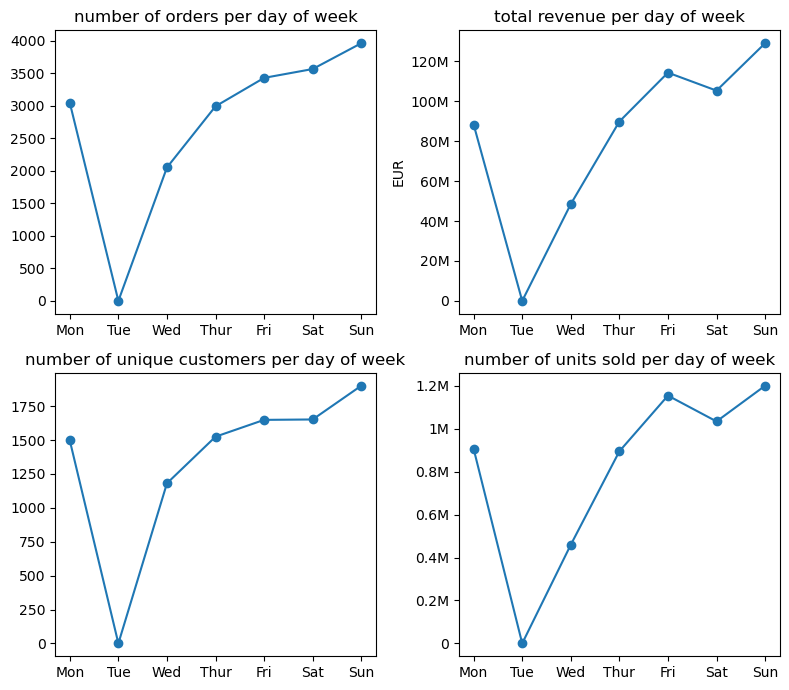

In [32]:
fig, ax = plt.subplots(2, 2, figsize = (8,7))

# number of orders per day of week
ax[0,0].plot(df_dow['day_of_week'], df_dow['num_orders'], marker = 'o')
ax[0,0].set_title('number of orders per day of week')
ax[0,0].set_xticks(list(range(7)))
ax[0,0].set_xticklabels(labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])

# total revenue per day of week
ax[0,1].plot(df_dow['day_of_week'], df_dow['total_revenue'], marker = 'o')
ax[0,1].set_title('total revenue per day of week')
ax[0,1].set_xticks(list(range(7)))
ax[0,1].set_xticklabels(labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
ax[0,1].set_yticks(ticks = range(0,140000000, 20000000))
ax[0,1].set_yticklabels(labels = ['0', '20M', '40M', '60M', '80M', '100M', '120M'])
ax[0,1].set_ylabel('EUR')

# number of unique customers per day of week
ax[1,0].plot(df_dow['day_of_week'], df_dow['num_unique_customers'], marker = 'o')
ax[1,0].set_title('number of unique customers per day of week')
ax[1,0].set_xticks(list(range(7)))
ax[1,0].set_xticklabels(labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])

# number of total units sold per day of week
ax[1,1].plot(df_dow['day_of_week'], df_dow['total_units_sold'], marker = 'o')
ax[1,1].set_title('number of units sold per day of week')
ax[1,1].set_xticks(list(range(7)))
ax[1,1].set_xticklabels(labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
ax[1,1].set_yticks(ticks = range(0,1400000, 200000))
ax[1,1].set_yticklabels(labels = ['0', '0.2M', '0.4M', '0.6M', '0.8M', '1M', '1.2M'])

plt.tight_layout()
plt.show()

<h4> 2.4) Customer buying pattern by month </h4>

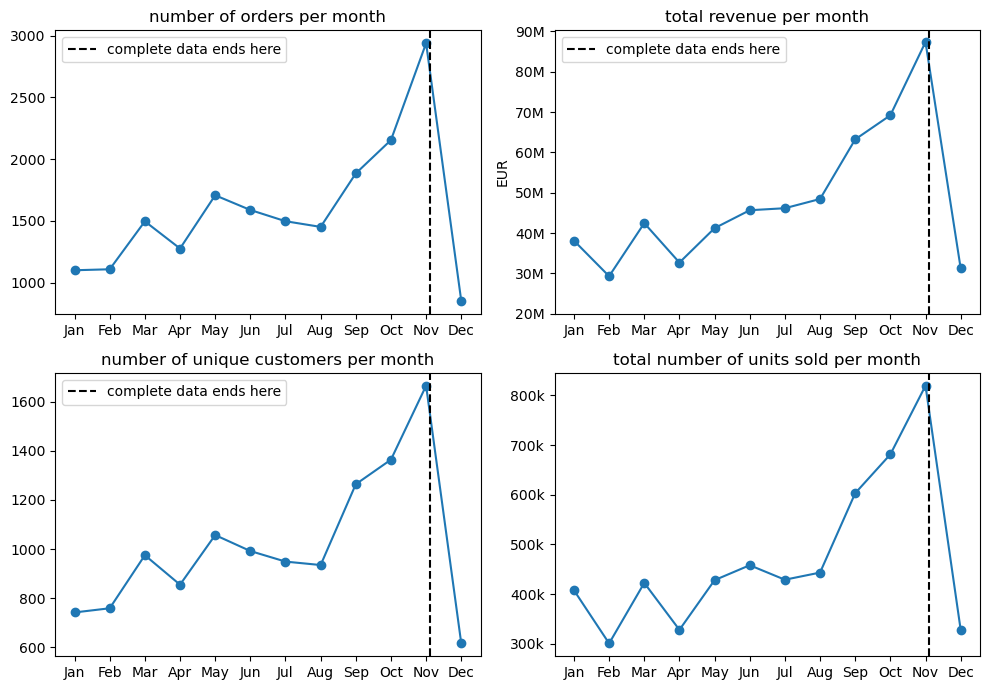

In [35]:
fig, ax = plt.subplots(2, 2, figsize = (10,7))

ax[0,0].plot(df_month['month'], df_month['num_orders'], marker = 'o')
ax[0,0].axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')
ax[0,0].set_title('number of orders per month')
ax[0,0].set_xticks(list(range(1,13,1)))
ax[0,0].set_xticklabels(labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[0,0].legend()

ax[0,1].plot(df_month['month'], df_month['total_revenue'], marker = 'o')
ax[0,1].axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')
ax[0,1].set_title('total revenue per month')
ax[0,1].set_xticks(list(range(1,13,1)))
ax[0,1].set_xticklabels(labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[0,1].set_yticks(ticks = list(range(20000000,90000001,10000000)))
ax[0,1].set_yticklabels(labels = ['20M', '30M', '40M', '50M', '60M', '70M', '80M', '90M'])
ax[0,1].set_ylabel('EUR')
ax[0,1].legend()

ax[1,0].plot(df_month['month'], df_month['num_unique_customers'], marker = 'o')
ax[1,0].axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')
ax[1,0].set_title('number of unique customers per month')
ax[1,0].set_xticks(list(range(1,13,1)))
ax[1,0].set_xticklabels(labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[1,0].legend()

ax[1,1].plot(df_month['month'], df_month['total_units_sold'], marker = 'o')
ax[1,1].axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')
ax[1,1].set_title('total number of units sold per month')
ax[1,1].set_xticks(list(range(1,13,1)))
ax[1,1].set_xticklabels(labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[1,1].set_yticklabels(labels = ['200k', '300k', '400k', '500k', '600k', '700k', '800k'])

plt.tight_layout()
plt.show()

<h4> 2.5) Customer buying pattern by hour </h4>

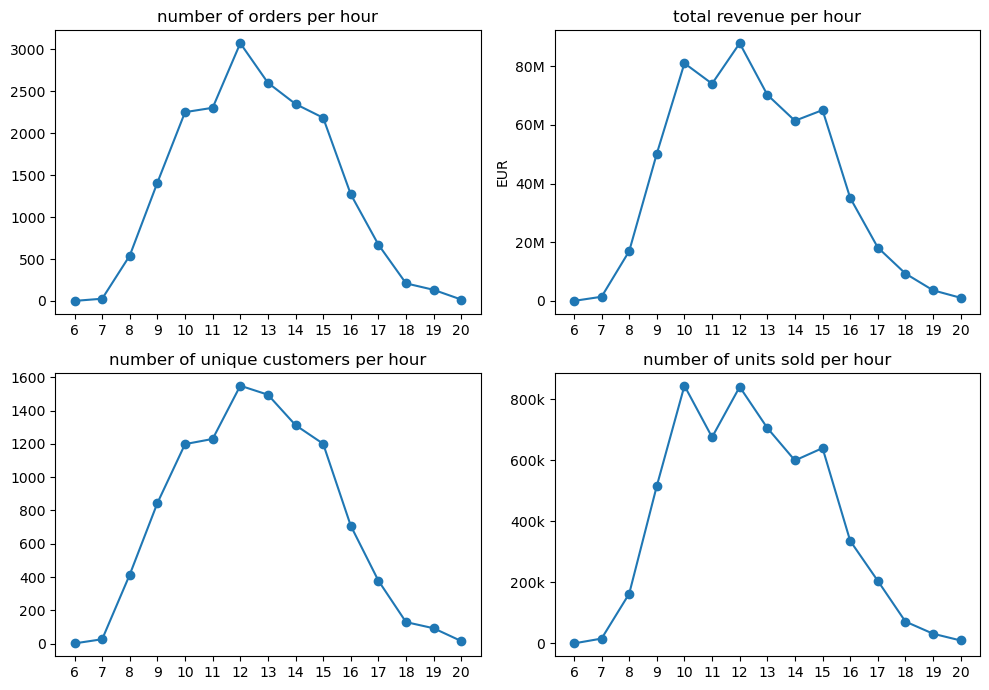

In [36]:
fig, ax = plt.subplots(2,2, figsize = (10, 7))

ax[0,0].plot(df_hour['hour'], df_hour['num_orders'], marker = 'o')
ax[0,0].set_title('number of orders per hour')
ax[0,0].set_xticks(ticks = list(range(6,21,1)))
ax[0,0].set_xticklabels(labels = list(range(6,21,1)))

ax[0,1].plot(df_hour['hour'], df_hour['total_revenue'], marker = 'o')
ax[0,1].set_title('total revenue per hour')
ax[0,1].set_xticks(ticks = list(range(6,21,1)))
ax[0,1].set_xticklabels(labels = list(range(6,21,1)))
ax[0,1].set_yticks(ticks = list(range(0,90000000, 20000000)))
ax[0,1].set_yticklabels(labels = ['0', '20M', '40M', '60M', '80M'])
ax[0,1].set_ylabel('EUR')

ax[1,0].plot(df_hour['hour'], df_hour['num_unique_customers'], marker = 'o')
ax[1,0].set_title('number of unique customers per hour')
ax[1,0].set_xticks(ticks = list(range(6,21,1)))
ax[1,0].set_xticklabels(labels = list(range(6,21,1)))

ax[1,1].plot(df_hour['hour'], df_hour['total_units_sold'], marker = 'o')
ax[1,1].set_title('number of units sold per hour')
ax[1,1].set_xticks(ticks = list(range(6,21,1)))
ax[1,1].set_xticklabels(labels = list(range(6,21,1)))
ax[1,1].set_yticks(ticks = list(range(0,900000, 200000)))
ax[1,1].set_yticklabels(labels = ['0', '200k', '400k', '600k', '800k'])

plt.tight_layout()
plt.show()

<h4> 2.6) Days in 2019 with unusual peaks and troughs in total_revenue </h4>

- To locate unusual peaks:
- Add column for the "rolling mean" and column for "total revenue - rolling mean"
- In particular, I want to see if the peaks or troughs correspond with weekends

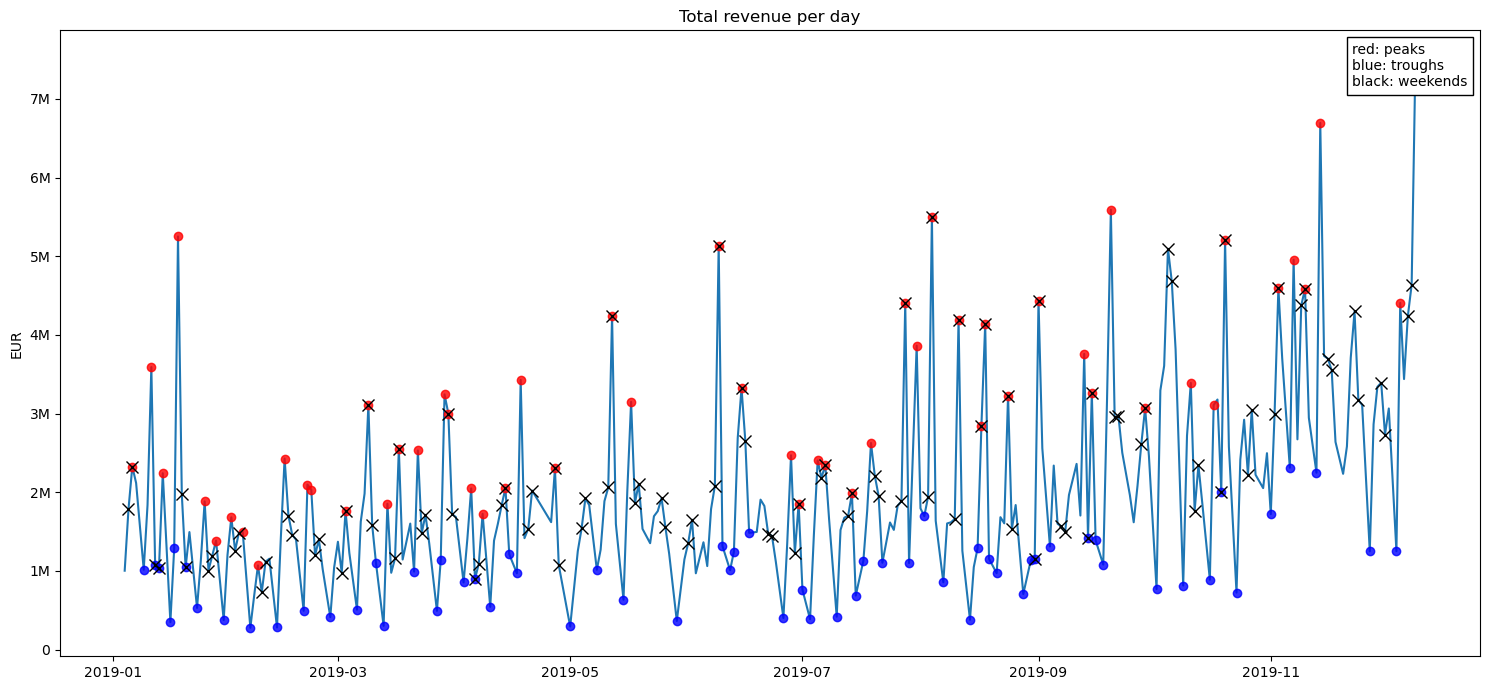

In [38]:
df_date ['total_revenue_rolling_mean'] = df_date['total_revenue'].rolling(5, center= True).mean()       # mean of current date + previous date + following date
df_date['total_revenue_minus_mean'] = df_date ['total_revenue'] - df_date ['total_revenue_rolling_mean'] # current value - mean value

# Convert invoice_date column to datetime format
df_date['invoice_date'] = pd.to_datetime(df_date['invoice_date'])

# Select unusual peaks and troughs
high_rev_dates = df_date[(df_date['total_revenue_rolling_mean']!= 'NaN')&(df_date['total_revenue_minus_mean']/df_date['total_revenue_rolling_mean']>0.3)] 
low_rev_dates = df_date[(df_date['total_revenue_rolling_mean']!= 'NaN')&(df_date['total_revenue_minus_mean']/df_date['total_revenue_rolling_mean']<-0.3)]

# Select just the weekends
weekends_2019 = df_date[df_date['invoice_date'].dt.dayofweek>4][['invoice_date','total_revenue']]

x = high_rev_dates ['invoice_date']
y = high_rev_dates ['total_revenue']

a = low_rev_dates ['invoice_date']
b = low_rev_dates ['total_revenue']

m = weekends_2019['invoice_date']
n = weekends_2019['total_revenue']


df_date_2019 = df_date [df_date['invoice_date'].dt.year == 2019]

fig, ax = plt.subplots(figsize = (15,7))
ax.plot (df_date_2019['invoice_date'], df_date_2019['total_revenue'], label = 'revenue')
for xy in zip (x,y):
    ax.plot(xy[0], xy[1], color = 'r', marker = 'o', label = 'high rev', alpha = 0.8)
    #plt.annotate(f'{xy[0].strftime("%d-%b")}', xy = xy)

for ab in zip (a,b):
    ax.plot(ab[0], ab[1], color = 'b', marker = 'o', alpha = 0.8)
    #plt.annotate(f'{ab[0].strftime("%d-%b")}', xy = ab)

for mn in zip (m,n):
    ax.plot(mn[0], mn[1], color = 'black', marker='x', markersize = 8, label = 'weekends')

at = AnchoredText ('red: peaks \nblue: troughs\nblack: weekends', frameon = True, loc = 'upper right')
ax.add_artist(at)

ax.set_yticks(ticks = list(range(0,8000000, 1000000)))
ax.set_yticklabels(labels = ['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M'])
ax.set_ylabel('EUR')
plt.title('Total revenue per day')
plt.tight_layout()
plt.show()

<h3> 3) EDA: ecommerce metrics </h3>

<h4> 3.1) Returning customer rate </h4>


In [39]:
def returning_customer_rate(measure_date):
    """
    Compute returning customer rate (number of existing customers making more than 1 order)
    This ignores "Null" customer_id values

    Arguments:
    date of measurement 

    Returns:
    (# customers making more than one order, total # customers, ratio between the two)
    """
    
    # slice dataframe within time_period
    df_slice = merged_table[(merged_table['invoice_date']< measure_date)]
    
    # for each customer_id, count number of unique orders (invoice_no)
    df_slice_agg = df_slice.groupby('customer_id')['invoice_no'].nunique().reset_index().rename(columns = {'invoice_no': 'num_orders'})
    
    # Count number of customers with more than one order, and at least one order, respectively
    more_than_one = df_slice_agg[df_slice_agg['num_orders'] > 1]['customer_id'].nunique()
    at_least_one = df_slice_agg[df_slice_agg['num_orders'] >= 1]['customer_id'].nunique()

    return more_than_one, at_least_one, round(100*more_than_one/at_least_one,2)
    

In [40]:
# compute returning_customer_rate for each month: 
measure_dates= ['2019-01-01', '2019-02-01','2019-03-01','2019-04-01','2019-05-01','2019-06-01','2019-07-01','2019-08-01',
                '2019-09-01','2019-10-01','2019-11-01','2019-12-01']

return_customers = []
total_num_customers = []
return_rates = []
for date in measure_dates:
    return_customers.append((returning_customer_rate(date))[0])
    total_num_customers.append((returning_customer_rate(date))[1])
    return_rates.append((returning_customer_rate(date))[2])

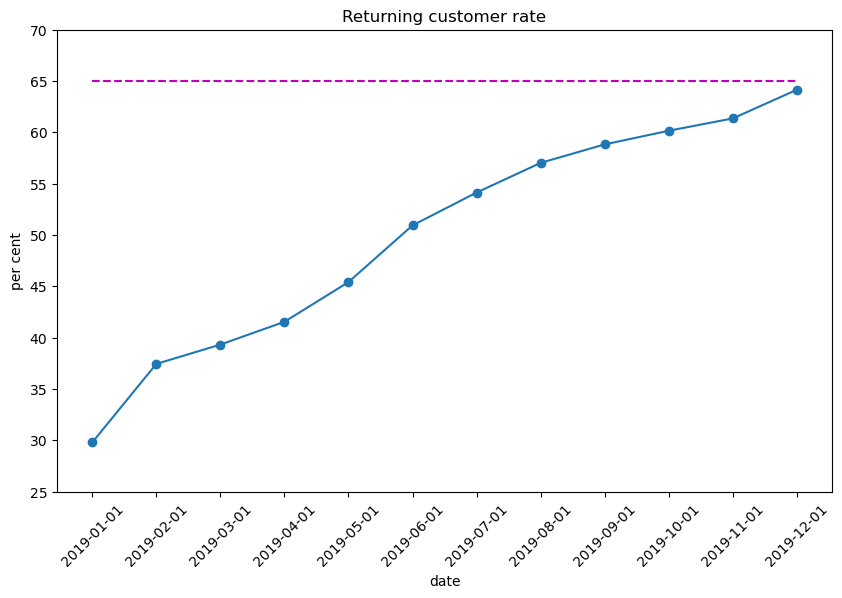

In [41]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.plot(measure_dates, return_rates, label = 'return rate', marker = 'o')
ax.set_xlabel('date')
ax.set_xticks(ticks = measure_dates)
ax.set_xticklabels(labels = measure_dates, rotation = 45)
ax.set(ylim = (25,70))
ax.set_ylabel('per cent')
ax.hlines(y=65, xmin = 0, xmax = 11, color='m', linestyle='--')
ax.set_title('Returning customer rate')
plt.show()

- Smaller percentage in the early months, because customers have had less time to make more than one purchase (the business launched in late 2018)  <br> 
- Towards the end, return rate reaches around 65%.
- In other words, by the end, around 65% of customers have made more than 1 purchase.

<h4> 2.2) Number of new customers </h4>

In [42]:
def num_new_customers(time_period):
    """
    Compute number of new customers within time_period

    Arguments:
    time_period -- (start_date, end_date)

    Returns:
    num_new_customers, num_all_customers
    """
    start_date, end_date = time_period
    
    # All customers by end of time period
    num_all_customers = merged_table[merged_table['invoice_date']<= end_date]['customer_id'].nunique()

    # existing customers before start_date:
    existing = merged_table[merged_table['invoice_date'] < start_date]['customer_id'].unique().tolist()

    # customers within time period
    df_slice = merged_table[(merged_table['invoice_date']>=start_date) & (merged_table['invoice_date']<=end_date)]['customer_id'].unique().tolist()



    new_customers = set(df_slice) - set(existing)
    num_new_customers = len(new_customers)

    return num_new_customers, num_all_customers

In [43]:
# compute number of new customers for each month: 
time_periods= [
                ('2018-12-01', '2018-12-31'), ('2019-01-01', '2019-01-31'), ('2019-02-01', '2019-02-31'), ('2019-03-01', '2019-03-31'),
                ('2019-04-01', '2019-04-31'), ('2019-05-01', '2019-05-31'), ('2019-06-01', '2019-06-31'), ('2019-07-01', '2019-07-31'),
                ('2019-08-01', '2019-08-31'), ('2019-09-01', '2019-09-31'), ('2019-10-01', '2019-10-31'), ('2019-11-01', '2019-11-31'),
                ('2019-12-01', '2019-12-31') ]

months = ['2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

all_customers = []
new_customer_counts = []

for time_period in time_periods:
    new_customer_counts.append(num_new_customers(time_period)[0])
    all_customers.append(num_new_customers(time_period)[1])



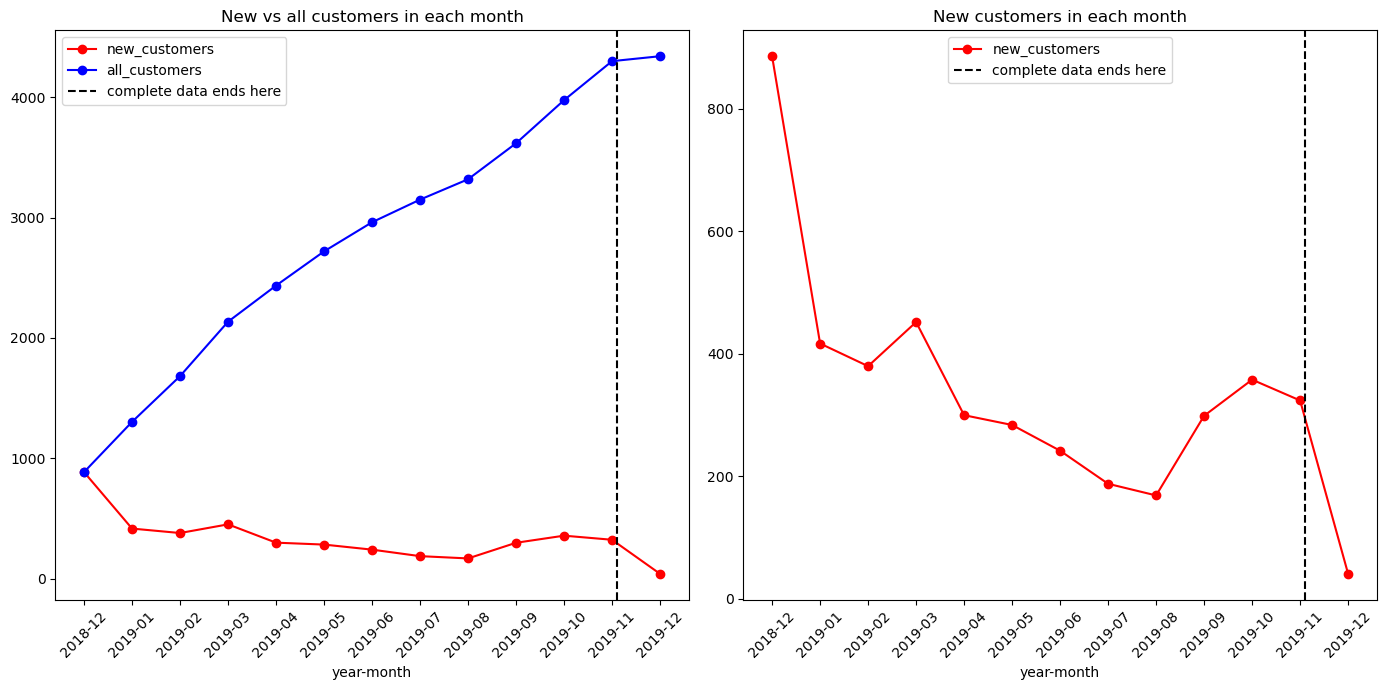

In [44]:
fig, ax = plt.subplots(1,2, figsize = (14,7))
ax[0].plot(months, new_customer_counts, color = 'r', label = 'new_customers', marker = 'o')
ax[0].plot(months, all_customers, color = 'b', label = 'all_customers', marker = 'o')
ax[0].axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')
ax[0].set_xlabel('year-month')
ax[0].set_xticks(ticks = months)
ax[0].set_xticklabels(labels = months, rotation = 45)
ax[0].legend()
ax[0].set_title('New vs all customers in each month')

ax[1].plot(months, new_customer_counts, color = 'r', label = 'new_customers', marker = 'o')
ax[1].axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')
ax[1].set_xlabel('year-month')
ax[1].set_xticks(ticks = months)
ax[1].set_xticklabels(labels = months, rotation = 45)
ax[1].set_title('New customers in each month')
ax[1].legend(loc = 'upper center')
plt.tight_layout()
plt.show()

<h4> 3.3) Idle customer rate </h4>

In [45]:
def idle_customers_1(time_period):
    """
    Compute number of idle customers within time_period
    In this version, we will also count the new customers during time period.

    Arguments:
    time_period -- (start_date, end_date)

    Returns:
    num_idle_customers, num_all_customers, num_idle_customers/num_all_customers
    
    """
    start_date, end_date = time_period

    # Customers who made a purchase within time_period
    purchasers = merged_table[(merged_table['invoice_date'] >= start_date) & (merged_table['invoice_date'] <= end_date)]['customer_id'].unique().tolist()

    # All existing customers within time_period
    existing = merged_table[(merged_table['invoice_date'] < end_date)]['customer_id'].unique().tolist()

    idle_customers = set(existing) - set(purchasers)

    num_idle_customers = len(idle_customers)
    num_all_customers = len(existing)

    return num_idle_customers, num_all_customers, round (100 * num_idle_customers / num_all_customers, 2)


In [46]:
def idle_customers_2(time_period):
    """
    Compute number of idle customers within time_period
    In this version, we will not count the new customers during the time period.
    Select all customers who existed in the system BEFORE the start date, and see how many of them made a purchase during the time period.

    Arguments:
    time_period -- (start_date, end_date)

    Returns:
    num_idle_customers, num_all_customers, num_idle_customers/num_all_customers
    
    """
    start_date, end_date = time_period

    # Customers who made a purchase within time_period
    purchasers = merged_table[(merged_table['invoice_date'] >= start_date) & (merged_table['invoice_date'] <= end_date)]['customer_id'].unique().tolist()

    # All existing customers within time_period
    existing = merged_table[(merged_table['invoice_date'] < start_date)]['customer_id'].unique().tolist()

    idle_customers = set(existing) - set(purchasers)

    num_idle_customers = len(idle_customers)
    num_all_customers = len(existing)

    return num_idle_customers, num_all_customers, round (100 * num_idle_customers / num_all_customers, 2)



In [47]:
time_periods= [
                ('2019-01-01', '2019-01-31'), ('2019-02-01', '2019-02-31'),
                ('2019-03-01', '2019-03-31'), ('2019-04-01', '2019-04-31'), ('2019-05-01', '2019-05-31'),
                ('2019-06-01', '2019-06-31'), ('2019-07-01', '2019-07-31'), ('2019-08-01', '2019-08-31'),
                ('2019-09-01', '2019-09-31'), ('2019-10-01', '2019-10-31'),('2019-11-01', '2019-11-31'),
                ('2019-12-01', '2019-12-31')
                ]

idle_customer_rates_1 = []
idle_customer_rates_2 = []
for time_period in time_periods:
    idle_customer_rates_1.append(idle_customers_1(time_period)[2])
    idle_customer_rates_2.append(idle_customers_2(time_period)[2])



In [48]:
# Calculate average for existing customers only:
sum(idle_customer_rates_2)/len(idle_customer_rates_2)

71.98166666666665

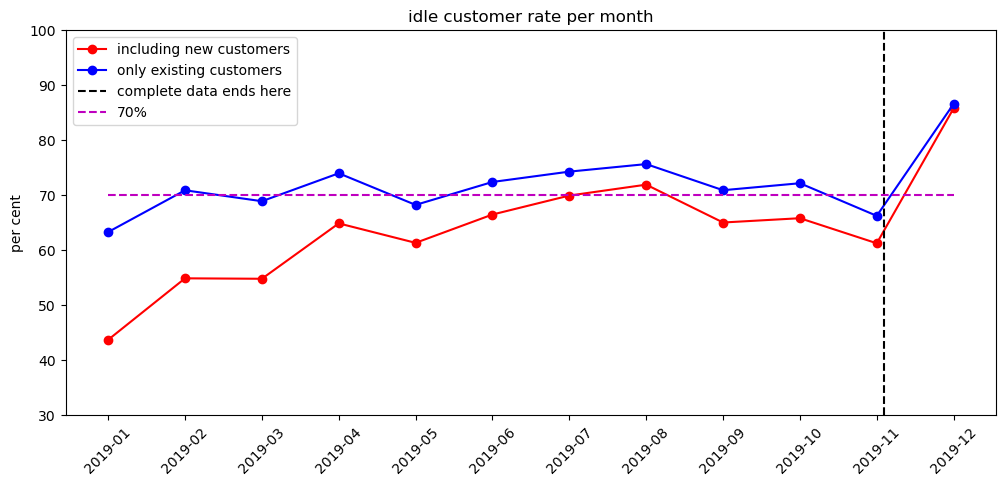

In [49]:
months = ['2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(months, idle_customer_rates_1, marker = 'o', color = 'r', label = 'including new customers')
ax.plot(months, idle_customer_rates_2, marker = 'o', color = 'b', label = 'only existing customers')
ax.axvline(x = 10.1, color = 'black', linestyle = '--', label = 'complete data ends here')
ax.hlines(y=70, xmin = 0, xmax = 11, color='m', linestyle='--', label = '70%')

ax.set_xticks(ticks = months)
ax.set_xticklabels(labels = months, rotation = 45)
ax.set_title('idle customer rate per month')
ax.set_ylabel('per cent')

ax.set(ylim = (30,100))

ax.legend()
plt.tight_layout
plt.show()

- Graph shows percentage of existing customers that DID NOT make a purchase in each month. <br>
- In most 30-day periods, around 70% of existing customers did not make a purchase
- Bear in mind that the data only goes up to 9 Dec 2019. So the unusually high idle customer rate in 2019–12 is misrepresentative. <br>
- The data begins in 2018–12, so idle customer rate is lower in the first month (2019-01), since we're dividing by a smaller number.


<h4> 3.4) Purchase rate (# orders per day within time period) </h4>

In [55]:
def purchase_rate(time_period):

    """
    Compute average number of orders per day

    Arguments:
    time_period -- (start_date, end_date)

    Returns:
    purchase_rate (num_orders / num_days)
    """

    start_date, end_date = time_period

    temp_df = merged_table[(merged_table['invoice_date']>= start_date) & (merged_table['invoice_date']<= end_date) & (merged_table['customer_id']!= 'Null')]
    num_invoices = len(temp_df['invoice_no'].unique())
    num_days = (datetime.datetime.strptime(end_date,'%Y-%m-%d') - datetime.datetime.strptime(start_date,'%Y-%m-%d')).days
    num_days
    purchase_rate = num_invoices/num_days
    return round(purchase_rate,2)
    

In [56]:
time_periods= [
                ('2018-12-01', '2018-12-31'), ('2019-01-01', '2019-01-31'), ('2019-02-01', '2019-02-28'),
                ('2019-03-01', '2019-03-31'), ('2019-04-01', '2019-04-30'), ('2019-05-01', '2019-05-31'),
                ('2019-06-01', '2019-06-30'), ('2019-07-01', '2019-07-31'), ('2019-08-01', '2019-08-31'),
                ('2019-09-01', '2019-09-30'), ('2019-10-01', '2019-10-31'), ('2019-11-01', '2019-11-30'),
                ('2019-12-01', '2019-12-31')
                ]

purchase_rates = []
for time_period in time_periods:
    purchase_rates.append(purchase_rate(time_period))

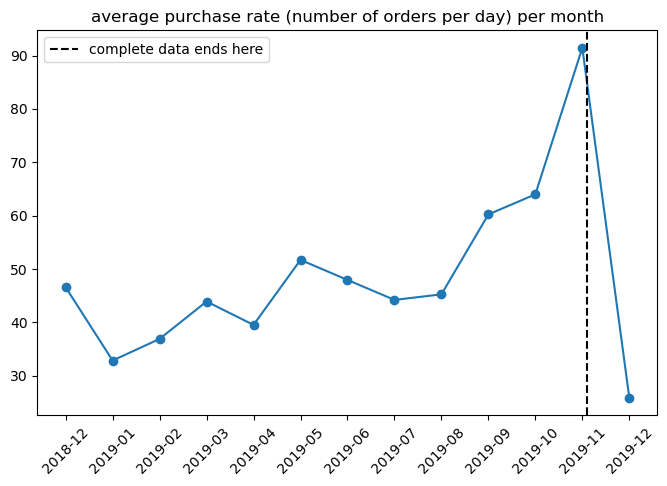

In [57]:
months = ['2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.plot(months,  purchase_rates, marker = 'o')
ax.axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')
ax.legend()
ax.set_xticks(ticks = months)
ax.set_xticklabels(labels = months, rotation = 45)
ax.set_title('average purchase rate (number of orders per day) per month')
plt.show()

- Again, data for 2019–12 is incomplete. So the purchase rate appears lower for that month.

- Let's now compute purchase rate for new vs existing customers. <br>

In [58]:
def purchase_rate_existing_vs_new(time_period):

    """
    Compute average number of orders per day

    Arguments:
    time_period -- (start_date, end_date)

    Returns:
    purchase_rate (num_orders / num_days)
    """

    start_date, end_date = time_period

    # all customers existing until BEFORE time period starts: 
    existing_customers = merged_table[(merged_table['invoice_date']<start_date) & (merged_table['customer_id']!= 'Null')]['customer_id'].unique().tolist()

    # all new customers during time period: 
    new_customers = merged_table[~(merged_table['customer_id'].isin(existing_customers)) & (merged_table['customer_id'] != 'Null')]['customer_id'].unique().tolist()

    # Slice dataframe for time period
    temp_df = merged_table[(merged_table['invoice_date']>= start_date) & (merged_table['invoice_date']<= end_date)]

    # Orders during time period by existing customers:
    existing_df = temp_df[temp_df['customer_id'].isin(existing_customers)]

    # Number of orders by existing customers:
    num_orders_existing = existing_df['invoice_no'].nunique()

    # Orders during time period by new customers:
    new_df = temp_df[temp_df['customer_id'].isin(new_customers)]

    # Number of orders by new customers:
    num_orders_new = new_df['invoice_no'].nunique()

    num_days = (datetime.datetime.strptime(end_date,'%Y-%m-%d') - datetime.datetime.strptime(start_date,'%Y-%m-%d')).days
    purchase_rate_existing = round (num_orders_existing/num_days , 2)
    purchase_rate_new = round (num_orders_new/num_days, 2)
    purchase_rate_total = purchase_rate_existing + purchase_rate_new
    return purchase_rate_existing, purchase_rate_new, purchase_rate_total

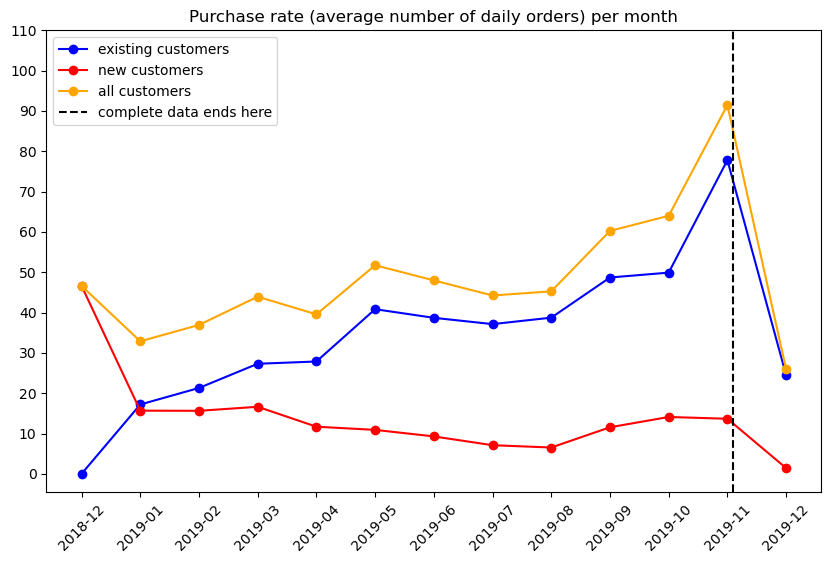

In [59]:
time_periods= [
                ('2018-12-01', '2018-12-31'), ('2019-01-01', '2019-01-31'), ('2019-02-01', '2019-02-28'),
                ('2019-03-01', '2019-03-31'), ('2019-04-01', '2019-04-30'), ('2019-05-01', '2019-05-31'),
                ('2019-06-01', '2019-06-30'), ('2019-07-01', '2019-07-31'), ('2019-08-01', '2019-08-31'),
                ('2019-09-01', '2019-09-30'), ('2019-10-01', '2019-10-31'), ('2019-11-01', '2019-11-30'),
                ('2019-12-01', '2019-12-31')
                ]

purchase_rates_existing = []
purchase_rates_new = []
purchase_rates_total = []
for time_period in time_periods:
    purchase_rates_existing.append(purchase_rate_existing_vs_new(time_period)[0])
    purchase_rates_new.append(purchase_rate_existing_vs_new(time_period)[1])
    purchase_rates_total.append(purchase_rate_existing_vs_new(time_period)[2])
months = ['2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.plot(months,  purchase_rates_existing, marker = 'o', color = 'blue', label = 'existing customers')
ax.plot(months,  purchase_rates_new, marker = 'o', color = 'red', label = 'new customers')
ax.plot(months,  purchase_rates_total, marker = 'o', color = 'orange', label = 'all customers')
ax.axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')

ax.set_xticks(ticks = months)
ax.set_xticklabels(labels = months, rotation = 45)
ax.set_yticks(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
ax.set_title('Purchase rate (average number of daily orders) per month')
ax.legend()
plt.show()

In [60]:
# Average purchase rate of first 11 months:
sum(purchase_rates_total[:-1])/11

54.97818181818182

- As the number of existing customers in the system grows, we see an increasing number of orders coming from existing customers. <br>
- Number of orders from new customers decreases
- This shows the importance of existing / repeat customers
- Also, we see that the number of customers grows over the course of the year, and this is NOT to be attributed to the increase in customer base through new customers!
- Currently only have one year's worth of data. So it's difficult to say what part of the general increase is seasonal <br>
(more purchases) towards second half of the year vs trend (as the platform establishes itself, it continuously sees more orders month on month)
- Regarding KPI: How we define it depends on whether the growth does or does not have seasonality to it. 
- If there's no seasonality, then we presume the same rate of month-on-month growth.
- If there is seasonality, we would have to set our target based on the entire subsequent year

<h4> 3.5) Average revenue per day (revenue per day within time period) </h4>

In [61]:
def average_revenue(time_period):

    """
    Compute average daily revenue within time_period by existing, new, and all customers.
    Existing customers are defined as customers who were in system before the start date.

    Arguments:
    time_period -- (start_date, end_date)

    Returns:
    avg_revenue_existing, avg_revenue_new, avg_revenue_both
    """

    start_date, end_date = time_period

    existing_customers = merged_table[(merged_table['invoice_date']<start_date) & (merged_table['customer_id']!= 'Null')]['customer_id'].unique().tolist()
    new_customers = merged_table[(~merged_table['customer_id'].isin(existing_customers)) & (merged_table['customer_id']!= 'Null')]['customer_id'].unique().tolist()

    df_temp = merged_table[(merged_table['invoice_date']>= start_date) & (merged_table['invoice_date']<= end_date)]

    total_revenue_existing = df_temp[df_temp['customer_id'].isin(existing_customers)]['total_sale'].sum()
    total_revenue_new = df_temp[df_temp['customer_id'].isin(new_customers)]['total_sale'].sum()

    num_days = (datetime.datetime.strptime(end_date,'%Y-%m-%d') - datetime.datetime.strptime(start_date,'%Y-%m-%d')).days

    avg_revenue_existing = total_revenue_existing / num_days
    avg_revenue_new = total_revenue_new / num_days
    avg_revenue_both = avg_revenue_existing + avg_revenue_new
    
    return avg_revenue_existing, avg_revenue_new, avg_revenue_both
    

In [62]:
time_periods= [
                ('2018-12-01', '2018-12-31'), ('2019-01-01', '2019-01-31'), ('2019-02-01', '2019-02-28'),
                ('2019-03-01', '2019-03-31'), ('2019-04-01', '2019-04-30'), ('2019-05-01', '2019-05-31'),
                ('2019-06-01', '2019-06-30'), ('2019-07-01', '2019-07-31'), ('2019-08-01', '2019-08-31'),
                ('2019-09-01', '2019-09-30'), ('2019-10-01', '2019-10-31'), ('2019-11-01', '2019-11-30'),
                ('2019-12-01', '2019-12-31')
                ]

average_revenues_existing = []
average_revenues_new = []
average_revenues_both = []
for time_period in time_periods:
    average_revenues_existing.append(average_revenue(time_period)[0])
    average_revenues_new.append(average_revenue(time_period)[1])
    average_revenues_both.append(average_revenue(time_period)[2])

months = ['2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']




In [63]:
time_periods= [
                ('2018-12-01', '2018-12-31'), ('2019-01-01', '2019-01-31'), ('2019-02-01', '2019-02-28'),
                ('2019-03-01', '2019-03-31'), ('2019-04-01', '2019-04-30'), ('2019-05-01', '2019-05-31'),
                ('2019-06-01', '2019-06-30'), ('2019-07-01', '2019-07-31'), ('2019-08-01', '2019-08-31'),
                ('2019-09-01', '2019-09-30'), ('2019-10-01', '2019-10-31'), ('2019-11-01', '2019-11-30'),
                ('2019-12-01', '2019-12-31')
                ]

purchase_rates_existing = []
purchase_rates_new = []
purchase_rates_total = []
for time_period in time_periods:
    purchase_rates_existing.append(purchase_rate_existing_vs_new(time_period)[0])
    purchase_rates_new.append(purchase_rate_existing_vs_new(time_period)[1])
    purchase_rates_total.append(purchase_rate_existing_vs_new(time_period)[2])
months = ['2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']


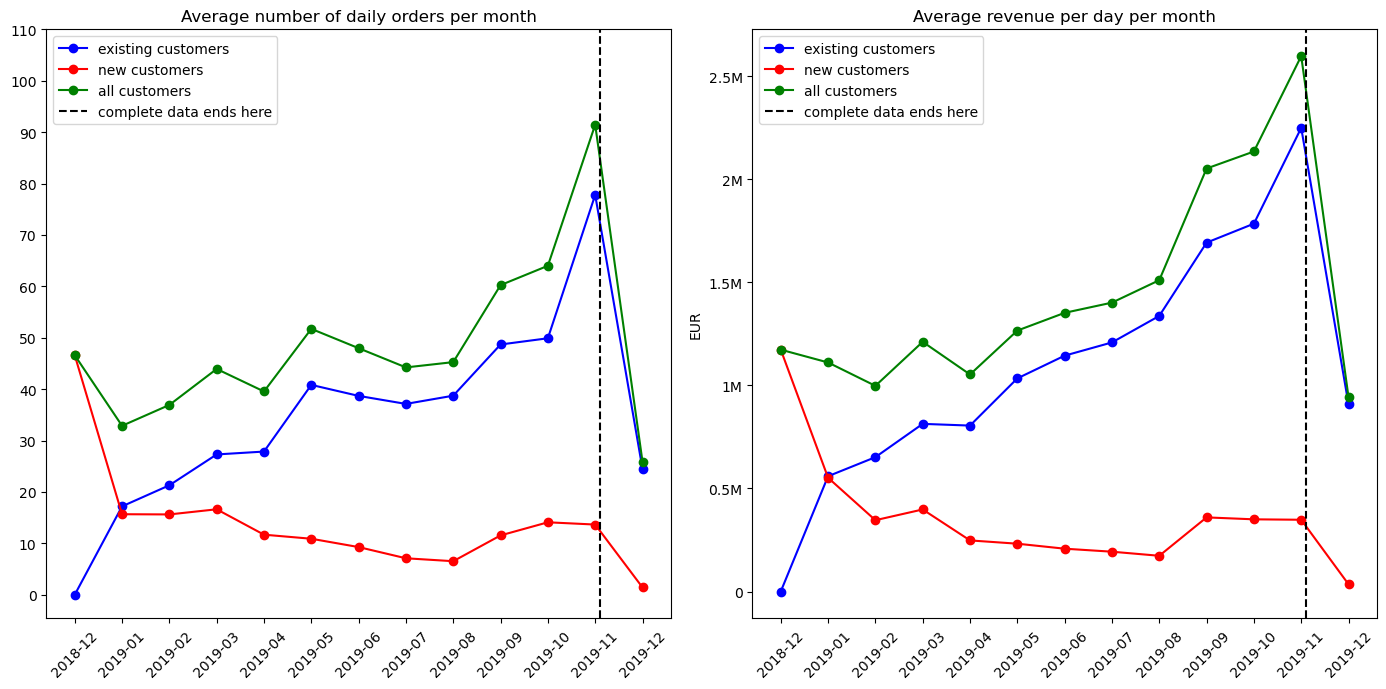

In [66]:
fig, ax = plt.subplots(1,2, figsize = (14,7))

ax[0].plot(months,  purchase_rates_existing, marker = 'o', color = 'blue', label = 'existing customers')
ax[0].plot(months,  purchase_rates_new, marker = 'o', color = 'red', label = 'new customers')
ax[0].plot(months,  purchase_rates_total, marker = 'o', color = 'green', label = 'all customers')
ax[0].axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')

ax[0].set_xticks(ticks = months)
ax[0].set_xticklabels(labels = months, rotation = 45)
ax[0].set_yticks(ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
ax[0].set_title('Average number of daily orders per month')
ax[0].legend()

ax[1].plot(months, average_revenues_existing, marker = 'o', color = 'blue', label = 'existing customers')
ax[1].plot(months, average_revenues_new, marker = 'o', color = 'red', label = 'new customers')
ax[1].plot(months, average_revenues_both, marker = 'o', color = 'green', label = 'all customers')
ax[1].axvline(x = 11.1, color = 'black', linestyle = '--', label = 'complete data ends here')

ax[1].set_title ('Average revenue per day per month')
ax[1].set_xticks(ticks = months)
ax[1].set_xticklabels(labels = months, rotation = 45)

ax[1].set_yticks(ticks = list(range(0,3000000,500000)))
ax[1].set_yticklabels(labels = ['0', '0.5M', '1M', '1.5M', '2M', '2.5M'])
ax[1].set_ylabel('EUR')
ax[1].legend()
plt.tight_layout()
plt.show()

In [67]:
# Compute average of "average daily revenue" from Jan 2019 to Nov 2019:
(sum(average_revenues_both[1:-1]) / 11)/1000000

1.516852959671543

- The above two graphs show us just how much money each order is worth.
- At most you have 100 orders per day. Yet the minimum revenue per day is 1 million.
- This means on average, each order is worth at least 10,000 euros. <br> <br>
- Note: the fact that both graphs show very similar trajectory is very informative. You might think that maybe the revenue is higher in the later half of the year because customers are making fewer orders but of greater value. But no, the number of orders and the size of revenue are closely correlated.
- Regarding KPI: same as earlier, depends on whether or not there is seasonality to the graph. 

<h4> 3.6) Purchase Details Per Customer </h4>

In [68]:
customer_info = merged_table.groupby('customer_id').agg({'invoice_no':'nunique', 'total_sale':'sum', 'product_id':'nunique'}).reset_index().rename(
                                        columns = {'total_sale':'total_revenue', 'invoice_no': 'num_orders', 'product_id':'num_products'}
                                                    ).sort_values(by = 'total_revenue', ascending = False)
customer_info['revenue_per_order'] = customer_info['total_revenue'] / customer_info['num_orders']
customer_info[customer_info['num_orders']==1]

customer_country = merged_table[['customer_id','country']].drop_duplicates()
customer_info = pd.merge(customer_info, customer_country, how = 'left', on = 'customer_id')
customer_info = customer_info[customer_info['customer_id']!= 'Null']

In [69]:
one_time = customer_info[customer_info['num_orders']==1]['total_revenue'].sum()
repeat = customer_info[(customer_info['num_orders']>1) & (customer_info['customer_id']!= 'Null')]['total_revenue'].sum()
anon = customer_info[customer_info['customer_id'] == 'Null']['total_revenue'].sum()
print(f'one-time buyers: {one_time/1000000} M euros \n repeat customers: {repeat/1000000} M euros \n anon buyers: {anon/1000000} M euros')

one-time buyers: 39.99977793 M euros 
 repeat customers: 515.39565007 M euros 
 anon buyers: 0.0 M euros


In [70]:
rev_per_customer_type = pd.DataFrame({'total_revenue (M EUR)': [round(one_time/1000000,2),round(repeat/1000000,2), round(anon/1000000,2)]}, index = ['one-time buyers', 'repeat customers', 'anon. buyers']).reset_index().rename(columns = {'index':'customer_type'})
rev_per_customer_type

,customer_type,total_revenue (M EUR)
0,one-time buyers,40.0
1,repeat customers,515.4
2,anon. buyers,0.0


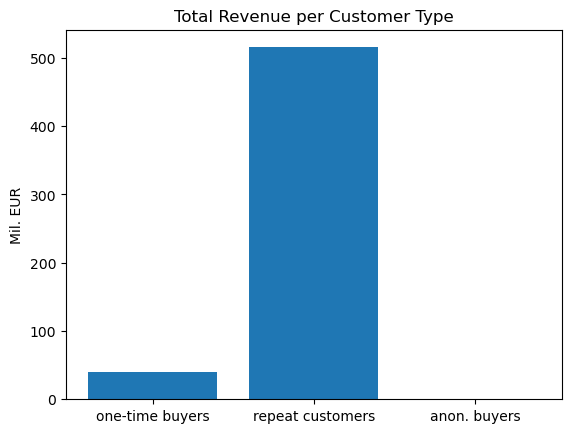

In [72]:
fig, ax = plt.subplots()
ax.bar(rev_per_customer_type['customer_type'],rev_per_customer_type['total_revenue (M EUR)'])
ax.set_ylabel('Mil. EUR')
ax.set_title('Total Revenue per Customer Type')
plt.show()

<h4> 3.7) Purchase Details per Country </h4>

- Countries with over 1M euros in revenue

In [73]:
by_country = merged_table[merged_table['invoice_datetime'].dt.year==2019].groupby('country')['total_sale'].sum().reset_index().sort_values(by = 'total_sale', ascending = False).rename(columns = {'total_sale':'total_revenue'})
by_country[by_country['total_revenue']>1000000]

,country,total_revenue
12,Germany,4.808830e+08
22,Netherlands,2.130295e+07
16,Ireland,1.539087e+07
33,United Kingdom,1.178792e+07
11,France,1.109539e+07
0,Australia,9.804246e+06
30,Sweden,3.936761e+06
19,Japan,2.747436e+06
31,Switzerland,2.717170e+06
29,Spain,2.691364e+06


- Revenue from Germany vs rest of the world

In [74]:
revenue_germany = by_country[by_country['country']=='Germany']['total_revenue'].sum()
revenue_row = by_country[by_country['country']!='Germany']['total_revenue'].sum()
print(f'Germany: {round(revenue_germany/1000000,2)} M euros\n Rest of world: {round(revenue_row/1000000,2)} M euros')

Germany: 480.88 M euros
 Rest of world: 94.38 M euros


In [75]:
germany_vs_row = pd.DataFrame({'total_revenue (M EUR)': [round(revenue_germany/1000000,2), round(revenue_row/1000000,2)]}, index = ['Germany', 'Rest of world']).reset_index().rename(columns = {'index':'country'})
germany_vs_row

,country,total_revenue (M EUR)
0,Germany,480.88
1,Rest of world,94.38


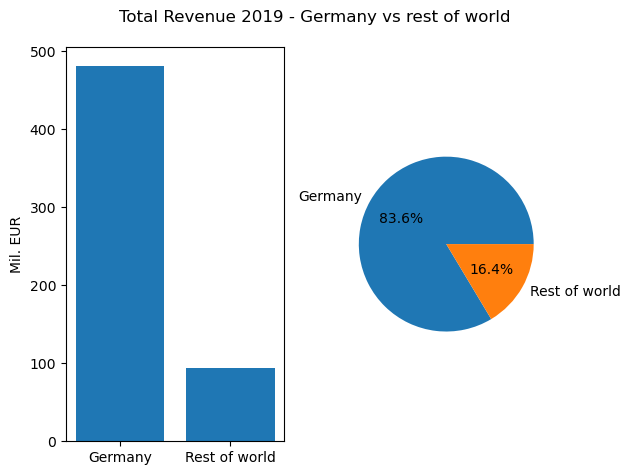

In [77]:
fig, ax = plt.subplots(1,2)
fig.set_facecolor('white')
fig.suptitle('Total Revenue 2019 - Germany vs rest of world')
ax[0].bar(germany_vs_row['country'], germany_vs_row['total_revenue (M EUR)'])
ax[0].set_ylabel('Mil. EUR')
ax[1].pie([germany_vs_row.iloc[0,:][1],germany_vs_row.iloc[1,:][1]], labels = ['Germany', 'Rest of world'],autopct='%1.1f%%')
plt.tight_layout()
plt.show()

<h4> 3.8) More Details on Customer and Country </h4>

In [78]:
summary = customer_info.groupby('country').agg({'customer_id': 'count', 'num_orders':'mean', 'total_revenue':['mean', 'sum'], 'revenue_per_order':'mean'}).reset_index()
summary.columns = ['country', 'num_customers', 'avg_orders_per_customer', 'avg_revenue_per_customer', 'total_revenue_country', 'avg_revenue_per_order']

summary['avg_orders_per_customer'] = round(summary['avg_orders_per_customer'],2)
summary['avg_revenue_per_customer'] = round(summary['avg_revenue_per_customer'],2)
summary['avg_revenue_per_order'] = round(summary['avg_revenue_per_order'],2)
summary = summary.sort_values(by = 'total_revenue_country', ascending = False)
# Select only countries with a total revenue of over 1 million euros
summary_top = summary[summary['total_revenue_country']>1000000]
summary_top.head()



,country,num_customers,avg_orders_per_customer,avg_revenue_per_customer,total_revenue_country,avg_revenue_per_order
12,Germany,3921,4.26,116490.81,4.567605e+08,24754.38
22,Netherlands,9,10.44,2444737.95,2.200264e+07,44677.06
15,Ireland,3,86.67,5101179.97,1.530354e+07,69986.00
33,United Kingdom,103,4.64,120268.34,1.238764e+07,32462.88
11,France,87,4.44,132080.92,1.149104e+07,26132.96


<h4> 3.8a) Total revenue per country (excluding Germany) </h4>

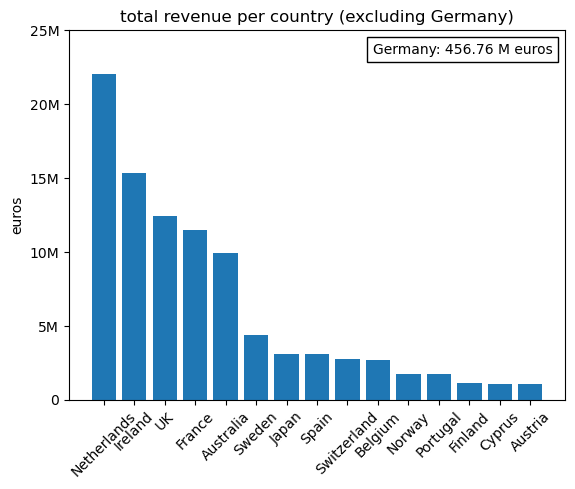

In [81]:
countries = summary_top['country'][1:]  # Select all countries except Germany
total_revenues = (summary_top['total_revenue_country']/1000000)[1:] # revenue in millions
countries
countries.values[2] = 'UK'             # Abbreviate 'United Kingdom' as 'UK' for plot

fig, ax = plt.subplots(1,1)
ax.bar(x = countries,  height = total_revenues)

ax.set_xticks(ticks = countries)
ax.set_xticklabels(labels = countries, rotation = 45)
ax.set_title('total revenue per country (excluding Germany)')
ax.set_yticks(ticks = list(range(0, 26,5)))
ax.set_yticklabels(labels = ['0', '5M','10M', '15M', '20M', '25M'])
ax.set_ylabel('euros')

at = AnchoredText ('Germany: 456.76 M euros', frameon = True, loc = 'upper right')
ax.add_artist(at)

plt.show()

- Let's focus on just the top five

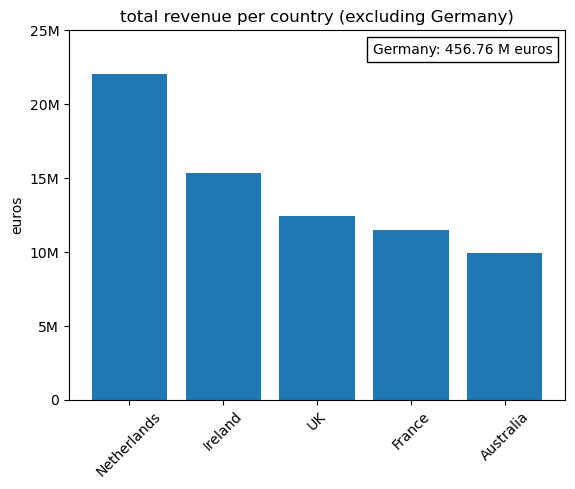

In [83]:
countries = summary_top['country'][1:6]  # Select all countries except Germany
total_revenues = (summary_top['total_revenue_country']/1000000)[1:6] # revenue in millions
countries
countries.values[2] = 'UK'             # Abbreviate 'United Kingdom' as 'UK' for plot

fig, ax = plt.subplots(1,1)
ax.bar(x = countries,  height = total_revenues)

ax.set_xticks(ticks = countries)
ax.set_xticklabels(labels = countries, rotation = 45)
ax.set_title('total revenue per country (excluding Germany)')
ax.set_yticks(ticks = list(range(0, 26,5)))
ax.set_yticklabels(labels = ['0', '5M','10M', '15M', '20M', '25M'])
ax.set_ylabel('euros')

at = AnchoredText ('Germany: 456.76 M euros', frameon = True, loc = 'upper right')
ax.add_artist(at)

plt.show()

<h4> 3.8b) Number of customers per country (excluding Germany) </h4>

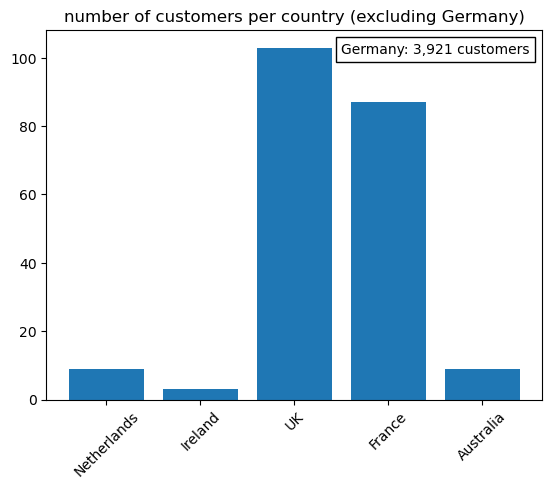

In [85]:
countries = summary_top['country'][1:6]
countries.values[2] = 'UK'
num_cust = summary_top['num_customers'][1:6]

fig, ax = plt.subplots(1,1)
ax.bar(x = countries,  height = num_cust)

ax.set_xticks(ticks = countries)
ax.set_xticklabels(labels = countries, rotation = 45)
ax.set_title('number of customers per country (excluding Germany)')
#ax.set_ylabel('euros')

at = AnchoredText ('Germany: 3,921 customers', frameon = True, loc = 'upper right')
ax.add_artist(at)

plt.show()

<h4> 3.8c) Average revenue per customer by country </h4>

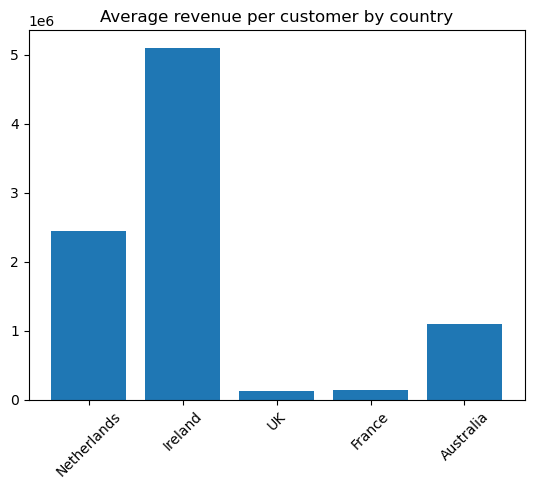

In [87]:
countries = summary_top['country'][1:6]
countries.values[2] = 'UK'
avg_rev_per_cust = summary_top['avg_revenue_per_customer'][1:6] # revenue in millions


fig, ax = plt.subplots(1,1)
ax.bar(x = countries,  height = avg_rev_per_cust)

ax.set_xticks(ticks = countries)
ax.set_xticklabels(labels = countries, rotation = 45)
ax.set_title('Average revenue per customer by country')

plt.show()

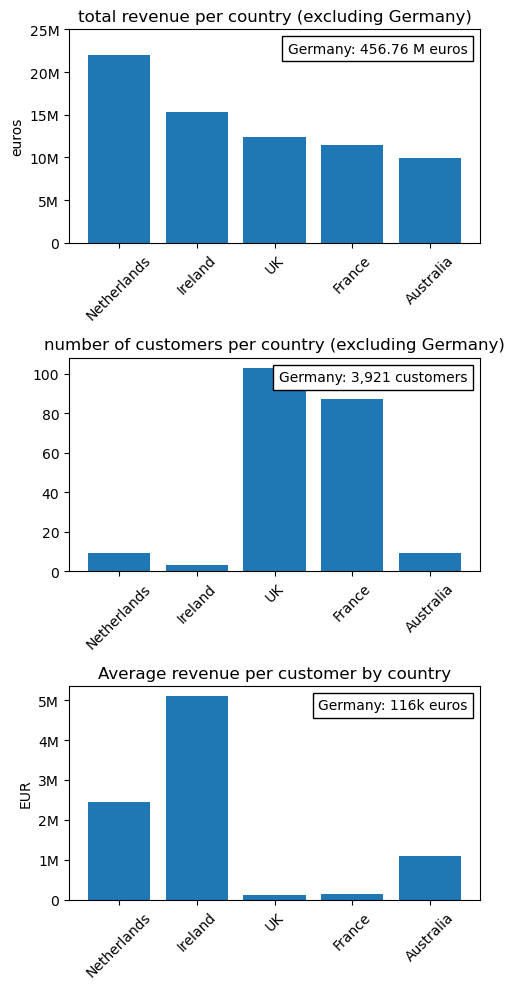

In [91]:
countries = summary_top['country'][1:6]  # Select all countries except Germany
countries.values[2] = 'UK'             # Abbreviate 'United Kingdom' as 'UK' for plot

total_revenues = (summary_top['total_revenue_country']/1000000)[1:6] # revenue in millions
num_cust = summary_top['num_customers'][1:6]
avg_rev_per_cust = summary_top['avg_revenue_per_customer'][1:6] # revenue in millions

fig, ax = plt.subplots(3,1, figsize = (5,10))

ax[0].bar(x = countries,  height = total_revenues)
ax[0].set_xticks(ticks = countries)
ax[0].set_xticklabels(labels = countries, rotation = 45)
ax[0].set_title('total revenue per country (excluding Germany)')
ax[0].set_yticks(ticks = list(range(0, 26,5)))
ax[0].set_yticklabels(labels = ['0', '5M','10M', '15M', '20M', '25M'])
ax[0].set_ylabel('euros')

at = AnchoredText ('Germany: 456.76 M euros', frameon = True, loc = 'upper right')
ax[0].add_artist(at)


ax[1].bar(x = countries,  height = num_cust)
ax[1].set_xticks(ticks = countries)
ax[1].set_xticklabels(labels = countries, rotation = 45)
ax[1].set_title('number of customers per country (excluding Germany)')
at = AnchoredText ('Germany: 3,921 customers', frameon = True, loc = 'upper right')
ax[1].add_artist(at)

ax[2].bar(x = countries,  height = avg_rev_per_cust)
ax[2].set_xticks(ticks = countries)
ax[2].set_xticklabels(labels = countries, rotation = 45)
ax[2].set_title('Average revenue per customer by country')
ax[2].set_yticks(ticks = list(range(0, 6000000,1000000)))
ax[2].set_yticklabels(labels = ['0', '1M','2M', '3M', '4M', '5M'])
ax[2].set_ylabel('EUR')
at = AnchoredText ('Germany: 116k euros', frameon = True, loc = 'upper right')
ax[2].add_artist(at)

plt.tight_layout()
plt.show()

- Ireland, Netherlands, Australia (in that order) have especially high-value customers (over 1M euros per customer in 2019)

<h4> 3.8d) Average revenue per order by country </h4>

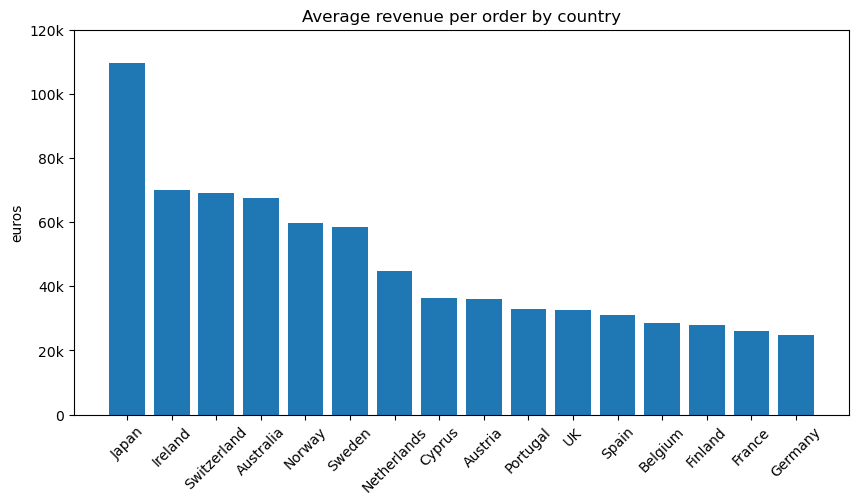

In [92]:
temp = summary_top.sort_values(by = 'avg_revenue_per_order', ascending = False).reset_index()

countries = temp['country']  # Select all countries except Germany
avg_rev_per_cust = (temp['avg_revenue_per_order']/1000) # revenue in thousands


fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.bar(x = countries,  height = avg_rev_per_cust)

ax.set_xticks(ticks = countries)
ax.set_xticklabels(labels = countries, rotation = 45)
ax.set_title('Average revenue per order by country')
ax.set_yticks(ticks = list(range(0, 121,20)))
ax.set_yticklabels(labels = ['0', '20k','40k', '60k', '80k', '100k', '120k'])
ax.set_ylabel('euros')

plt.show()

- Still staggering that on average, the top countries' customers spend at least 30k per order
- Customers in Japan spend, on average, over 100k per order

<h4> 3.9) Private vs Business customers </h4>

- In 2019, how many customers spent over 100k? Over 10k? 

In [93]:
top_revenue = merged_table[merged_table['invoice_datetime'].dt.year == 2019].groupby('customer_id')['total_sale'].sum().reset_index().rename(columns = {'total_sale':'total_revenue'})
#top_revenue['total_revenue (in m)'] = top_revenue['total_revenue (in m)'] / 1000000
top_revenue = top_revenue.sort_values(by = 'total_revenue', ascending = False)
top_revenue = top_revenue[top_revenue['customer_id']!= 'Null']

# Check how many customers spent more than 100,000:
customers_100k = top_revenue[top_revenue['total_revenue']>100000]        # 1062 rows

# Check how many customers spent more than 10,000:
customers_10k = top_revenue[top_revenue['total_revenue']>10000]       # 3473 rows

all_customers_2019 = merged_table[merged_table['invoice_datetime'].dt.year == 2019]['customer_id'].nunique()

print (f' over 100k: {len(customers_100k)} customers\n over 10k: {len (customers_10k)} customers\n total: {all_customers_2019} customers')

 over 100k: 1062 customers
 over 10k: 3473 customers
 total: 4221 customers


- Wow. Okay, so around 75% of all customers spent over 10k in 2019 alone. This means a huge number of customers are business customers.

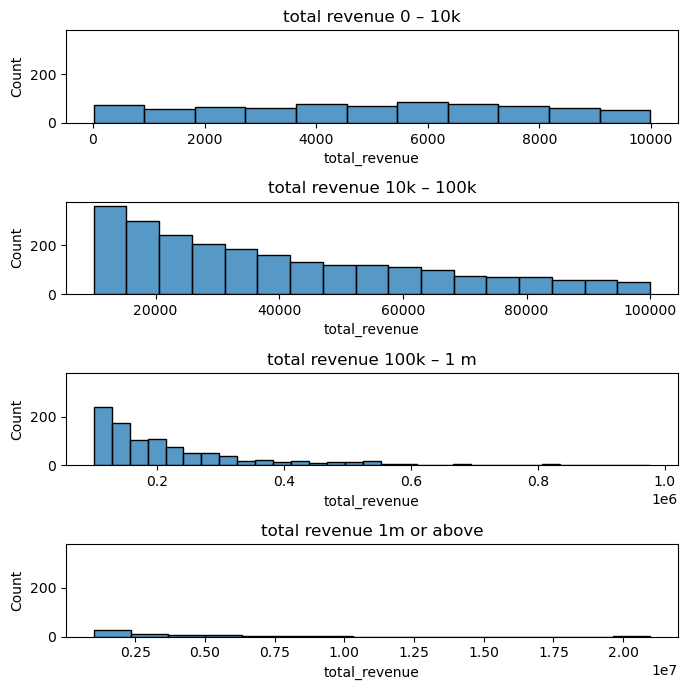

In [95]:
# Provisional division lines: 
# 0 – 10k
# 10k – 100k
# 100k or above

fig, ax = plt.subplots(4,1, figsize = (7,7), sharey = True)
# 0 – 10k
sns.histplot(ax = ax[0], x = top_revenue [top_revenue['total_revenue']< 10000]['total_revenue'])
ax[0].set_title('total revenue 0 – 10k')
# 10k – 100k
sns.histplot(ax = ax[1], x = top_revenue [(top_revenue['total_revenue']>= 10000) & (top_revenue['total_revenue']< 100000)]['total_revenue'])
ax[1].set_title('total revenue 10k – 100k')

# 100k–1m
sns.histplot(ax = ax[2], x = top_revenue [(top_revenue['total_revenue']>= 100000) &(top_revenue['total_revenue']< 1000000)]['total_revenue'])
ax[2].set_title('total revenue 100k – 1 m')

# 1m or above
sns.histplot(ax = ax[3], x = top_revenue [(top_revenue['total_revenue']>= 1000000)]['total_revenue'])
ax[3].set_title('total revenue 1m or above')

plt.tight_layout()
plt.show()

In [96]:
# 0 – 10k -- private customers

customers_0_10k = top_revenue[(top_revenue['total_revenue']>0)&(top_revenue['total_revenue']<10000)]

# 10k – 100k -- small business customers
customers_10k_100k = top_revenue[(top_revenue['total_revenue']>=10000)&(top_revenue['total_revenue']<100000)]

# 100k–1m -- medium business customers
customers_100k_1m = top_revenue[(top_revenue['total_revenue']>=100000)&(top_revenue['total_revenue']<1000000)]

# 1m or above -- big business customers
customers_1m_or_above = top_revenue[(top_revenue['total_revenue']>=1000000)]

private_vs_business = pd.DataFrame({'revenue': ['0–10k', '10k–100k', '100k–1m',  '> 1m'], 
                                    'num_customers': [len(customers_0_10k), len(customers_10k_100k), len(customers_100k_1m), len(customers_1m_or_above)],
                                    'total_revenue': [customers_0_10k['total_revenue'].sum(), customers_10k_100k['total_revenue'].sum(),customers_100k_1m['total_revenue'].sum(),customers_1m_or_above['total_revenue'].sum()]})

private_vs_business

,revenue,num_customers,total_revenue
0,0–10k,747,3.696538e+06
1,10k–100k,2411,9.634739e+07
2,100k–1m,1007,2.340513e+08
3,> 1m,55,1.847115e+08


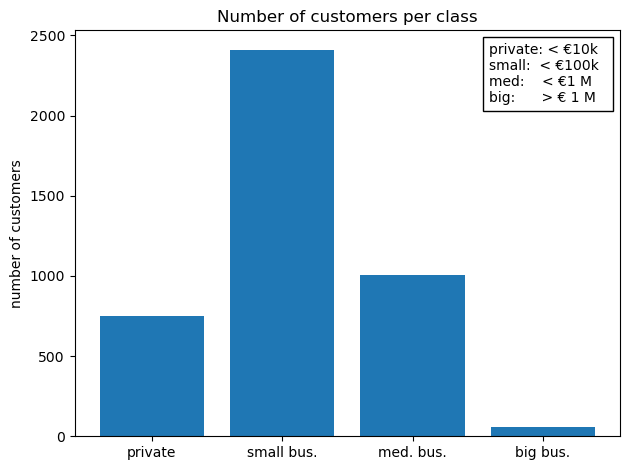

In [97]:
fig, ax = plt.subplots(1,1)

ax.bar(private_vs_business['revenue'],private_vs_business['num_customers'])
ax.set_xticks(ticks = [0,1,2,3])
ax.set_xticklabels(labels = ['private', 'small bus.', 'med. bus.', 'big bus.'])
ax.set_title('Number of customers per class')
ax.set_ylabel('number of customers')

at = AnchoredText ('private: < €10k \nsmall:  < €100k  \nmed:    < €1 M \nbig:      > € 1 M ', frameon = True, loc = 'upper right')
ax.add_artist(at)
plt.tight_layout()
plt.show()

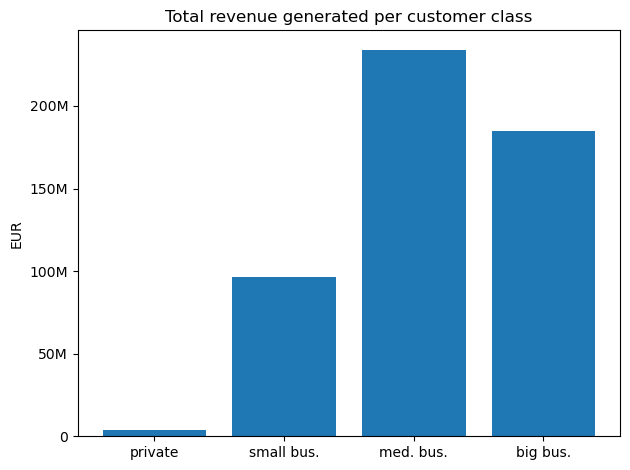

In [98]:
fig, ax = plt.subplots(1,1)


ax.bar(private_vs_business['revenue'], private_vs_business['total_revenue'])
ax.set_xticks(ticks = [0,1,2,3])
ax.set_xticklabels(labels = ['private', 'small bus.', 'med. bus.', 'big bus.'])
ax.set_yticks(ticks = list(range(0, 250000000, 50000000)))
ax.set_yticklabels(labels = ['0', '50M', '100M', '150M', '200M'])
ax.set_title('Total revenue generated per customer class')
ax.set_ylabel('EUR')


plt.tight_layout()
plt.show()

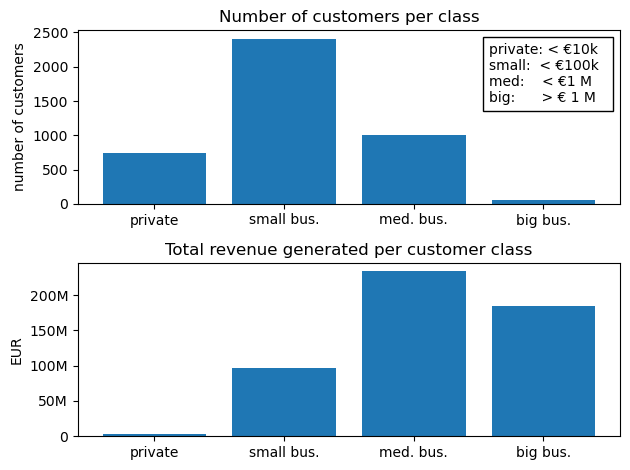

In [99]:
fig, ax = plt.subplots(2,1)

ax[0].bar(private_vs_business['revenue'],private_vs_business['num_customers'])
ax[0].set_xticks(ticks = [0,1,2,3])
ax[0].set_xticklabels(labels = ['private', 'small bus.', 'med. bus.', 'big bus.'])
ax[0].set_title('Number of customers per class')
ax[0].set_ylabel('number of customers')

at = AnchoredText ('private: < €10k \nsmall:  < €100k  \nmed:    < €1 M \nbig:      > € 1 M ', frameon = True, loc = 'upper right')
ax[0].add_artist(at)

ax[1].bar(private_vs_business['revenue'], private_vs_business['total_revenue'])
ax[1].set_xticks(ticks = [0,1,2,3])
ax[1].set_xticklabels(labels = ['private', 'small bus.', 'med. bus.', 'big bus.'])
ax[1].set_yticks(ticks = list(range(0, 250000000, 50000000)))
ax[1].set_yticklabels(labels = ['0', '50M', '100M', '150M', '200M'])
ax[1].set_title('Total revenue generated per customer class')
ax[1].set_ylabel('EUR')

#at = AnchoredText ('private: < €10k \nsmall:  < €100k  \nmed:    < €1 M \nbig:      > € 1 M ', frameon = True, loc = 'upper right')
#ax[1].add_artist(at)

plt.tight_layout()
plt.show()

Ok this is interesting: <br>

- A rather small number of customers (747 out of 4220) are private users
- The majority of customers are business customers, which we have (quit arbitrarily) divided into three classes: small, medium, big
- This means we want to cater to the non-private customers as a priority
- Find out if there is a difference in the kinds of products private vs business customers tend to buy

<h4> 3.10) Days since last purchase </h4>

In [100]:
def most_recent_order (measure_date):
    """
    Return average number of days since last order for all existing customers

    Arguments:
    measure_date -- single date, in format 'yyyy-mm-dd'

    Returns:
    Average number of days since last order
    
    """
    
    dummy = merged_table.copy(deep = True)
    # Select only rows where invoice date is BEFORE measure date
    dummy['before_measure_date'] = dummy['invoice_datetime'] < measure_date 
    dummy = dummy[dummy['before_measure_date'] == True]
    # Create new df showing most recent order date before measure date
    dummy = dummy.groupby('customer_id')['invoice_date'].max().reset_index().rename(columns = {'invoice_date': 'last_order'})
    dummy['measure_date'] = measure_date
    dummy['last_order'] = pd.to_datetime(dummy['last_order'])
    dummy['measure_date'] = pd.to_datetime(dummy['measure_date'])
    dummy['days_since_last_order'] =  (dummy['measure_date'] - dummy['last_order']).dt.days
    return round (dummy['days_since_last_order'].mean(),2)

In [101]:
measure_dates = ['2019-01-01','2019-02-01','2019-03-01','2019-04-01','2019-05-01','2019-06-01','2019-07-01',
                '2019-08-01','2019-09-01','2019-10-01','2019-11-01','2019-12-01', ]
days_since_last_order = []
for date in measure_dates:
    days_since_last_order.append(most_recent_order(date))


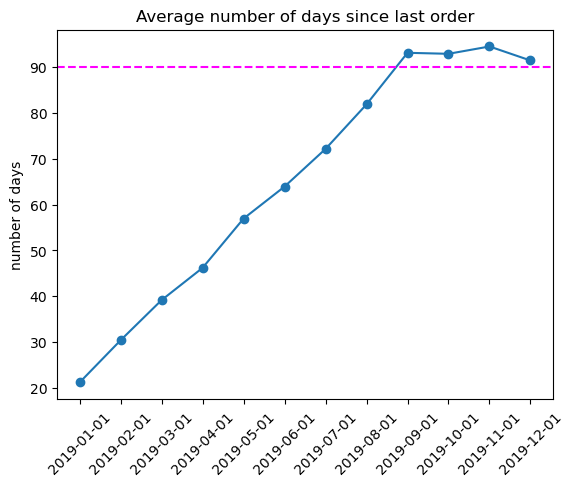

In [103]:
fig, ax = plt.subplots(1,1)
ax.plot(measure_dates, days_since_last_order, marker = 'o')
ax.axhline(y = 90, color = 'magenta', linestyle = '--', label = '90 days')

ax.set_title('Average number of days since last order')
ax.set_xticks(measure_dates)
ax.set_xticklabels(measure_dates, rotation = 45)
ax.set_ylabel('number of days')
plt.show()

In [104]:
#Average of last four data points:
sum(days_since_last_order[-1:-5:-1])/4

93.03

- Seems to plateau at around 90 days. 
- Given available data, have to assume this trend continues.
- On average, customers make a purchase once every 90 days

In [105]:
start_date = datetime.date(2019, 1, 1)
number_of_days = 365
date_list = [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(0, number_of_days, 15)] # Date every 15 days

days_since_last_order = []
for date in date_list:
    days_since_last_order.append(most_recent_order(date))


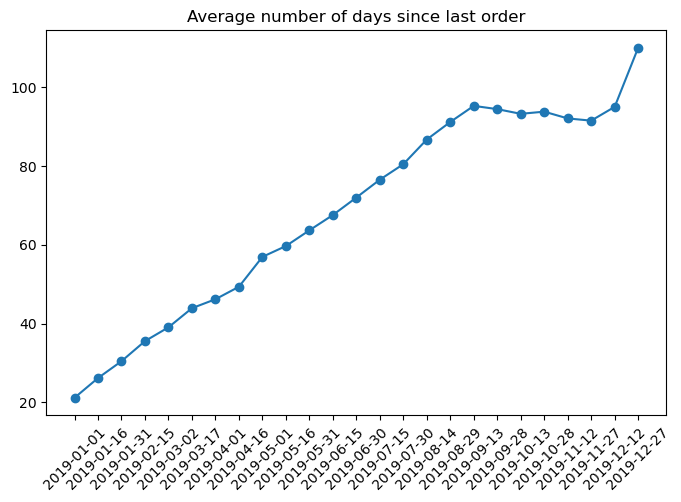

In [109]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.plot(date_list, days_since_last_order, marker = 'o')
ax.set_title('Average number of days since last order')
ax.set_xticks(date_list)
ax.set_xticklabels(date_list, rotation = 45)
plt.show()

<h4> 3.11) Top and bottom selling products </h4>

In [110]:
products = merged_table[['product_id', 'unit_price', 'rating', 'review_count', 'product_name', 'product_type']]
products = products.drop_duplicates()
print(products['product_type'].unique())

['dslr camera' 'keyboard' 'monitor' 'mouse' 'processor' 'smartphone']


- 6 product_types: dslr camera, keyboard, monitor, mouse, processor, smartphone

<h4> 3.11a) Top products, sorted by product types </h4>

In [111]:
product_sales = merged_table.groupby(['product_type', 'product_id'])[['quantity', 'total_sale']].sum().reset_index().sort_values(by = ['product_type','total_sale'], ascending = False)
product_sales.rename(columns = {'total_sale':'total_revenue'}, inplace = True)
product_sales = pd.merge(product_sales, products, how = 'left', on = 'product_id').drop('product_type_y', axis =1).rename(columns = {'product_type_x':'product_type'})

# Number of unique customers per product
product_num_customers = merged_table.groupby('product_id')[['customer_id']].nunique().reset_index().rename(columns = {'customer_id':'num_customers'}).sort_values(by = 'num_customers', ascending=False)
product_num_customers[product_num_customers['product_id']!= 'Null']
product_sales = pd.merge(product_sales, product_num_customers, how = 'left', on = 'product_id')
product_sales = product_sales[product_sales['product_id']!= 'Null']

top_camera = product_sales[product_sales['product_type'] == 'dslr camera']
top_keyboard = product_sales[product_sales['product_type'] == 'keyboard']
top_monitor = product_sales[product_sales['product_type'] == 'monitor']
top_mouse = product_sales[product_sales['product_type'] == 'mouse']
top_processor = product_sales[product_sales['product_type'] == 'processor']
top_smartphone = product_sales[product_sales['product_type'] == 'smartphone']



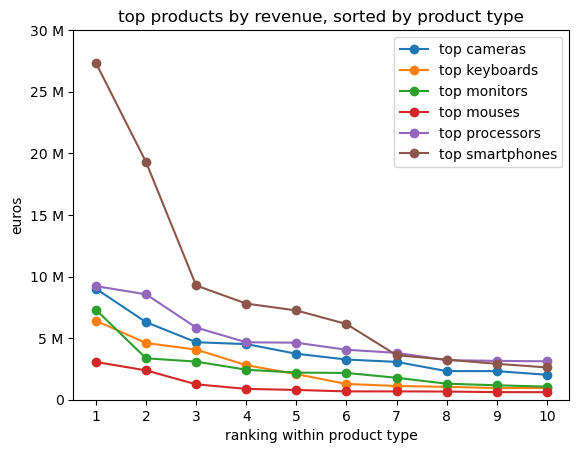

In [113]:
fig, ax = plt.subplots(1,1)
ax.plot(list(range(10)), top_camera['total_revenue'][:10]/1000000, marker = 'o', label = 'top cameras')
ax.plot(list(range(10)), top_keyboard['total_revenue'][:10]/1000000, marker = 'o', label = 'top keyboards')
ax.plot(list(range(10)), top_monitor['total_revenue'][:10]/1000000, marker = 'o', label = 'top monitors')
ax.plot(list(range(10)), top_mouse['total_revenue'][:10]/1000000, marker = 'o', label = 'top mouses')
ax.plot(list(range(10)), top_processor['total_revenue'][:10]/1000000, marker = 'o', label = 'top processors')
ax.plot(list(range(10)), top_smartphone['total_revenue'][:10]/1000000, marker = 'o', label = 'top smartphones')

ax.set_title('top products by revenue, sorted by product type')

ax.set_ylim(0,30)
ax.set_xticks(ticks = list(range(10)))
ax.set_xticklabels (labels = list(range(1,11)))
ax.set_yticks(ticks = list(range(0,31,5)))
ax.set_yticklabels(labels = ['0', '5 M', '10 M', '15 M', '20 M', '25 M', '30 M'])
ax.set_ylabel('euros')
ax.set_xlabel('ranking within product type')

ax.legend()
plt.show()

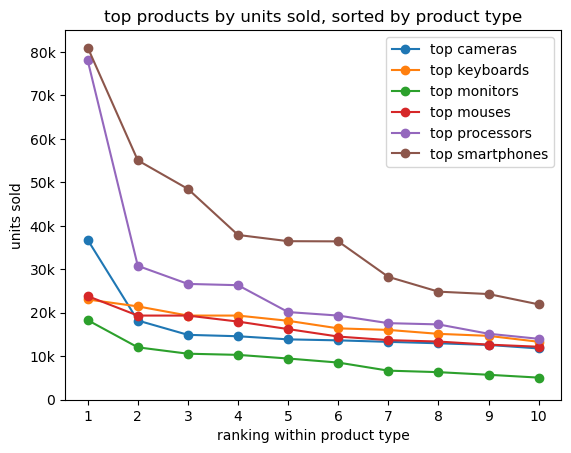

In [114]:
fig, ax = plt.subplots(1,1)
ax.plot(list(range(10)), top_camera.sort_values(by = 'quantity', ascending = False)['quantity'][:10]/1000, marker = 'o', label = 'top cameras')
ax.plot(list(range(10)), top_keyboard.sort_values(by = 'quantity', ascending = False)['quantity'][:10]/1000, marker = 'o', label = 'top keyboards')
ax.plot(list(range(10)), top_monitor.sort_values(by = 'quantity', ascending = False)['quantity'][:10]/1000, marker = 'o', label = 'top monitors')
ax.plot(list(range(10)), top_mouse.sort_values(by = 'quantity', ascending = False)['quantity'][:10]/1000, marker = 'o', label = 'top mouses')
ax.plot(list(range(10)), top_processor.sort_values(by = 'quantity', ascending = False)['quantity'][:10]/1000, marker = 'o', label = 'top processors')
ax.plot(list(range(10)), top_smartphone.sort_values(by = 'quantity', ascending = False)['quantity'][:10]/1000, marker = 'o', label = 'top smartphones')

ax.set_title('top products by units sold, sorted by product type')

ax.set_ylim(0,85)
ax.set_xticks(ticks = list(range(10)))
ax.set_xticklabels (labels = list(range(1,11)))
ax.set_yticks(ticks = list(range(0,81,10)))
ax.set_yticklabels(labels = ['0', '10k', '20k', '30k', '40k', '50k', '60k','70k','80k'])
ax.set_ylabel('units sold')
ax.set_xlabel('ranking within product type')

ax.legend()
plt.show()

In [115]:
product_sales.describe()

,quantity,total_revenue,unit_price,rating,review_count,num_customers
count,4664.000000,4.664000e+03,4664.000000,4664.000000,4664.000000,4664.000000
mean,1375.987993,1.365279e+05,106.393808,4.263679,814.111707,65.048027
std,3371.508175,7.036373e+05,227.026944,0.361564,2485.257125,87.450747
min,1.000000,5.900000e+00,5.040000,2.300000,27.000000,1.000000
25%,60.000000,1.830027e+03,14.990000,4.100000,122.000000,7.000000
50%,350.500000,1.253850e+04,29.980000,4.300000,240.000000,31.000000
75%,1381.250000,6.715448e+04,88.990000,4.500000,624.250000,88.000000
max,80995.000000,2.732705e+07,3999.110000,4.900000,63885.000000,882.000000


- median for total revenue is around 12k
- bottom quartile for total revenue is around 1.8k

In [116]:
product_sales['product_id'].nunique()

4133

- There are 4133 unique products

<h4> 3.11b) Top 10 products </h4>

In [117]:
top_10_products = product_sales.sort_values(by = 'total_revenue', ascending = False).head(10).drop(['product_id'], axis = 1)[['product_type', 'product_name','unit_price', 'total_revenue', 'quantity', 'num_customers']]
top_10_products['total_revenue'] = round(top_10_products['total_revenue'] / 1000000,2)
top_10_products = top_10_products.rename(columns = {'total_revenue':'total_revenue_mill_EUR', 'quantity':'units_sold'})
top_10_products.index = list(range(1,11,1))
top_10_products['units_per_customer'] = round(top_10_products['units_sold'] / top_10_products['num_customers'])
top_10_products[['product_type','product_name']]

,product_type,product_name
1,smartphone,Samsung Galaxy S9 G960U 64GB Unlocked 4G LTE P...
2,smartphone,"Apple iPhone X, 256GB, Silver - Fully Unlocked..."
3,smartphone,Samsung Galaxy S10+ Plus 128GB+8GB RAM SM-G975...
4,processor,Intel Core i7-8700K Desktop Processor 6 Cores ...
5,dslr camera,Canon EF 17-40mm f/4L USM Ultra Wide Angle Zoo...
6,processor,(Renewed) Latest Microsoft Surface Pro 4 (2736...
7,smartphone,"Xiaomi Redmi Note 8 Pro 64GB, 6GB RAM 6.53"" LT..."
8,monitor,ASUS ROG Swift PG248Q 24â€ Gaming Monitor Ful...
9,smartphone,Fitbit Versa 2 Health and Fitness Smartwatch w...
10,keyboard,"Acer Aspire 5 A515-55-56VK, 15.6"" Full HD IPS ..."


<h4> 3.11c) performance of different product price categories </h4>

In [118]:
product_sales['unit_price'].describe()

product_sales[product_sales['unit_price']<10]['product_id'].nunique()
product_sales[product_sales['unit_price']<10]['total_revenue'].sum()
product_sales[product_sales['unit_price']<10]['quantity'].sum()

products_1_to_10 = product_sales[product_sales['unit_price']<10]
products_10_to_100 = product_sales[(product_sales['unit_price']>=10)&(product_sales['unit_price']<100)]
products_100_to_1000 = product_sales[(product_sales['unit_price']>=100)&(product_sales['unit_price']<1000)]
products_1000_to_10k = product_sales[(product_sales['unit_price']>=1000)&(product_sales['unit_price']<10000)]

products_1_to_10['product_id'].nunique(), products_1_to_10['total_revenue'].sum(), products_1_to_10['quantity'].sum()


price_cat_df = pd.DataFrame({'num_products': [products_1_to_10['product_id'].nunique(), products_10_to_100['product_id'].nunique(), 
                                products_100_to_1000['product_id'].nunique(), products_1000_to_10k['product_id'].nunique()],
                'units_sold': [products_1_to_10['quantity'].sum(), products_10_to_100['quantity'].sum(), 
                                products_100_to_1000['quantity'].sum(), products_1000_to_10k['quantity'].sum()], 
                'total_revenue': [products_1_to_10['total_revenue'].sum(), products_10_to_100['total_revenue'].sum(), 
                                products_100_to_1000['total_revenue'].sum(), products_1000_to_10k['total_revenue'].sum()]},
                                index = ['0 – 10 EUR', '10 – 100 EUR', '100 – 1000 EUR', '1000 – 10k EUR']).reset_index().rename(columns = {'index': 'product_category'})

price_cat_df

,product_category,num_products,units_sold,total_revenue
0,0 – 10 EUR,601,581083,4.770411e+06
1,10 – 100 EUR,2573,4324415,1.492730e+08
2,100 – 1000 EUR,905,1483245,4.402038e+08
3,1000 – 10k EUR,54,28865,4.251906e+07


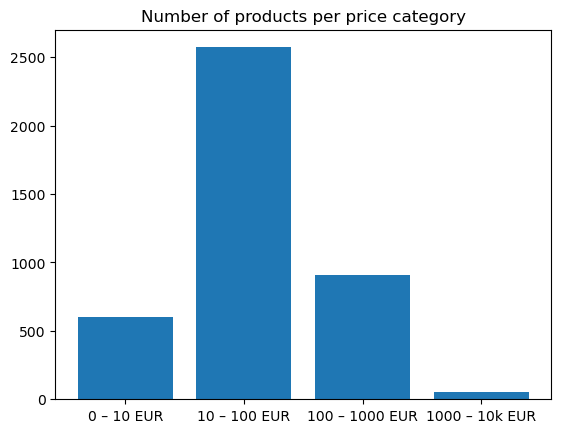

In [119]:
fig, ax = plt.subplots(1,1)
ax.bar(price_cat_df['product_category'], price_cat_df['num_products'])
ax.set_title('Number of products per price category')
plt.show()

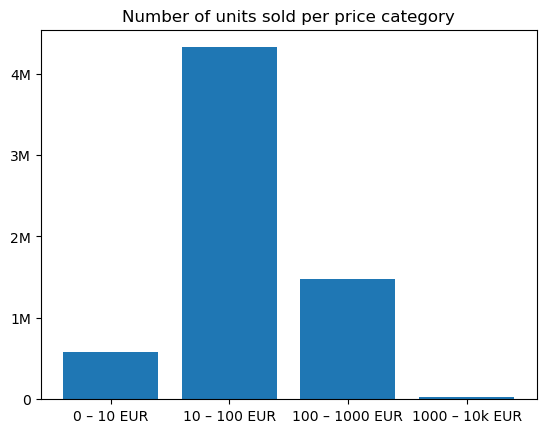

In [120]:
fig, ax = plt.subplots(1,1)
ax.bar(price_cat_df['product_category'], price_cat_df['units_sold'])
ax.set_title('Number of units sold per price category')
ax.set_yticks(ticks = list(range(0, 5000000, 1000000)))
ax.set_yticklabels(labels = ['0', '1M', '2M','3M','4M'])

plt.show()

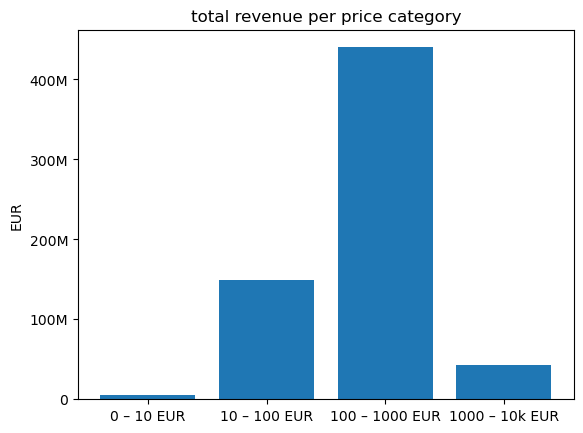

In [121]:
fig, ax = plt.subplots(1,1)

ax.bar(price_cat_df['product_category'], price_cat_df['total_revenue'])
ax.set_title('total revenue per price category')
ax.set_yticks(ticks = list(range(0, 500000000, 100000000)))
ax.set_yticklabels(labels = ['0', '100M', '200M','300M','400M'])
ax.set_ylabel('EUR')
plt.show()

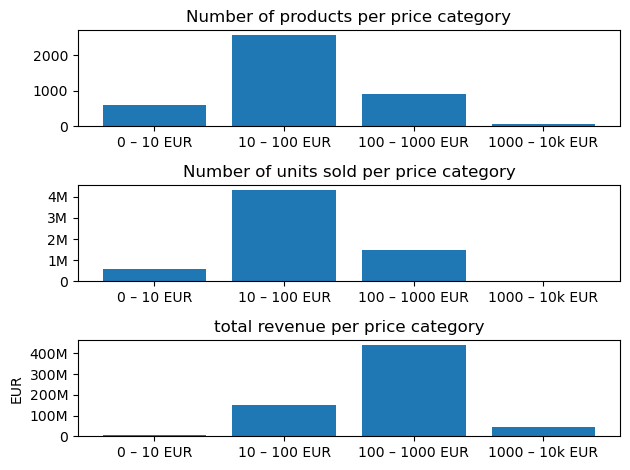

In [122]:
fig, ax = plt.subplots(3,1)
ax[0].bar(price_cat_df['product_category'], price_cat_df['num_products'])
ax[0].set_title('Number of products per price category')

ax[1].bar(price_cat_df['product_category'], price_cat_df['units_sold'])
ax[1].set_title('Number of units sold per price category')
ax[1].set_yticks(ticks = list(range(0, 5000000, 1000000)))
ax[1].set_yticklabels(labels = ['0', '1M', '2M','3M','4M'])

ax[2].bar(price_cat_df['product_category'], price_cat_df['total_revenue'])
ax[2].set_title('total revenue per price category')
ax[2].set_yticks(ticks = list(range(0, 500000000, 100000000)))
ax[2].set_yticklabels(labels = ['0', '100M', '200M','300M','400M'])
ax[2].set_ylabel('EUR')

plt.tight_layout()
plt.show()

- Go through each category one by one:
- 0 to 10 euro category: sizable number of units sold, but tiny proportion of total revenue
- 10 to 100 euro category: highest number of products, by far highest number of units sold, but significantly less in total revenue
- 100 to 1000 euro category: not as many units sold, but by far biggest revenue generator
- 1000 to 10k euro category: tiny tiny number of units sold, yet still sizable amount of revenue

<h4> 3.12) Unregistered customers </h4>

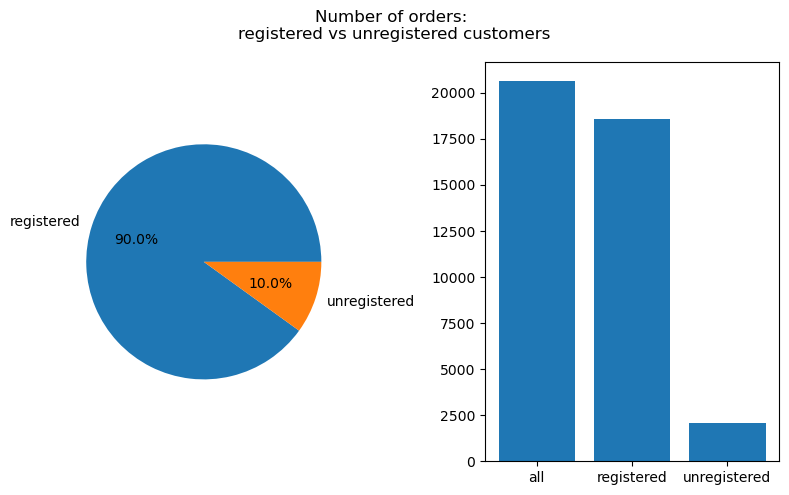

In [125]:
all_customers = merged_table['invoice_no'].nunique()
registered_customers = merged_table[merged_table['customer_id']!= 'Null']['invoice_no'].nunique()
unregistered_customers = merged_table[merged_table['customer_id']=='Null']['invoice_no'].nunique()

fig, ax = plt.subplots(1,2, figsize = (8, 5))
fig.set_facecolor('white')
fig.suptitle('Number of orders: \nregistered vs unregistered customers')
ax[0].pie([registered_customers, unregistered_customers], labels = ['registered', 'unregistered'],autopct='%1.1f%%')
ax[1].bar(x = ['all', 'registered', 'unregistered'], height = [all_customers, registered_customers, unregistered_customers])
plt.tight_layout()
plt.show()

- Around 10% of all orders were by unregistered customers

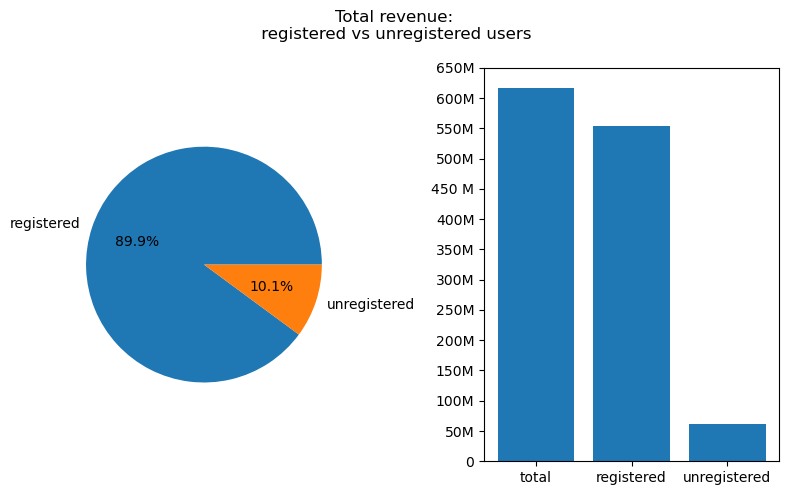

In [127]:
total_rev = merged_table['total_sale'].sum()/1000000
registered_rev = merged_table[merged_table['customer_id']!= 'Null']['total_sale'].sum()/1000000
unregistered_rev = merged_table[merged_table['customer_id']== 'Null']['total_sale'].sum()/1000000


fig, ax = plt.subplots(1,2, figsize = (8,5))
fig.set_facecolor('white')
fig.suptitle('Total revenue:\n registered vs unregistered users')
ax[0].pie([registered_rev, unregistered_rev], labels = ['registered', 'unregistered'],autopct='%1.1f%%')
ax[1].bar(x = ['total', 'registered', 'unregistered'], height = [total_rev, registered_rev, unregistered_rev])
ax[1].set_yticks(ticks = list(range(0,700, 50)))
ax[1].set_yticklabels(labels = ['0', '50M', '100M', '150M', '200M', '250M', '300M', '350M', '400M', '450 M', '500M', '550M', '600M', '650M'])

plt.tight_layout()
plt.show()


- Around 10% of all revenue also from unregistered customers

<h4> 3.13) Purchase frequency </h4>

In [128]:
def purchase_frequency(time_period):
    """
    Computes purchase frequency (number of orders / number of customers) for input period

    Arguments: time_period (start_date, end_date)

    Returns: purchase frequency
    """

    start_date, end_date = time_period
    
    # List of unique customers
    all_customers = merged_table[(merged_table['invoice_datetime']<= end_date)& (merged_table['customer_id']!= 'Null')]['customer_id'].unique().tolist()
    
    df_slice = merged_table[(merged_table['invoice_datetime']>= start_date) & (merged_table['invoice_datetime']<= end_date)]

    # df with number of invoices per customer
    num_orders_per_customer = df_slice[df_slice['customer_id'].isin(all_customers)].groupby('customer_id')['invoice_no'].nunique().reset_index().rename(columns = {'invoice_no':'num_invoices'})

    # Number of customers
    num_customers = len(all_customers)

    # Total number of orders
    total_num_orders = num_orders_per_customer['num_invoices'].sum()

    # Purchase rate
    purchase_rate1 = total_num_orders/num_customers
    return purchase_rate1

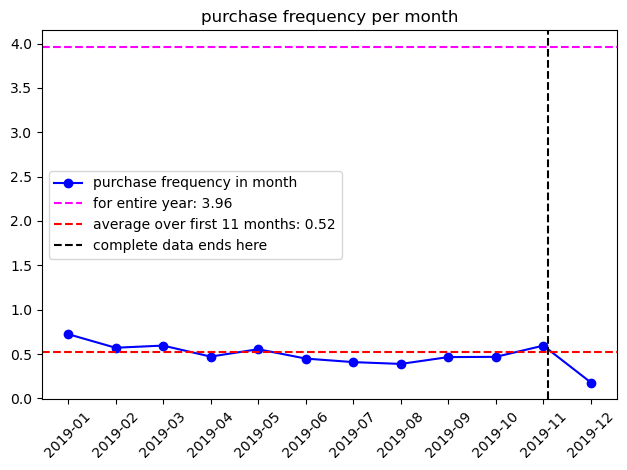

In [130]:
time_periods= [
                ('2019-01-01', '2019-01-31'), ('2019-02-01', '2019-02-28'),
                ('2019-03-01', '2019-03-31'), ('2019-04-01', '2019-04-30'), ('2019-05-01', '2019-05-31'),
                ('2019-06-01', '2019-06-30'), ('2019-07-01', '2019-07-31'), ('2019-08-01', '2019-08-31'),
                ('2019-09-01', '2019-09-30'), ('2019-10-01', '2019-10-31'), ('2019-11-01', '2019-11-30'),
                ('2019-12-01', '2019-12-31')
                ]

purchase_frequencies = []

for time_period in time_periods:
    purchase_frequencies.append(purchase_frequency(time_period))

months = ['2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig, ax = plt.subplots(1,1)

ax.plot(months,  purchase_frequencies, marker = 'o', color = 'blue', label = 'purchase frequency in month')

#ax.axvline(x = 10.1, color = 'black', linestyle = '--', label = 'complete data ends here')
ax.axhline(y = 3.96, color = 'magenta', linestyle = '--', label = 'for entire year: 3.96')
ax.axhline(y = 0.52, color = 'red', linestyle = '--', label = 'average over first 11 months: 0.52')
ax.axvline(x = 10.1, color = 'black', linestyle = '--', label = 'complete data ends here')

ax.set_xticks(ticks = months)
ax.set_xticklabels(labels = months, rotation = 45)

ax.legend()
ax.set_title('purchase frequency per month')

plt.tight_layout()
plt.show()



In [131]:
purchase_frequency(('2019-01-01', '2019-12-31')), sum(purchase_frequencies[:-1])/len(purchase_frequencies[:-1])

(3.957593915648767, 0.5174293819344148)

In [132]:
max(purchase_frequencies), min (purchase_frequencies[:-1])

(0.7246489859594384, 0.38858695652173914)

<h4> 3.14) Repeat customer rate </h4>

In [133]:
def repeat_customer_rate(time_period):
    """
    Compute repeat customer rate for time period
    This ignores "Null" customer_id values

    Arguments:
    time_period (start_date, end_date)

    Returns:
    # customers who are repeat customers / all customers who make a purchase
    """

    start_date, end_date = time_period
    
    # dataframe slice for time period
    df_slice = merged_table[(merged_table['invoice_date']>= start_date) & (merged_table['invoice_date']<= end_date)]

    df_slice = df_slice[df_slice['customer_id']!= 'Null']

    # All customers who made a purchase in time period
    purchasing_customers = df_slice['customer_id'].unique().tolist()


    # For each customer who made a purchase in time period, count number of unique orders by the end of the time period
    customers_df = merged_table[(merged_table['customer_id'].isin(purchasing_customers)) & (merged_table['invoice_date']<= end_date)].groupby('customer_id')['invoice_no'].nunique().reset_index().rename(columns = {'invoice_no': 'num_orders'})

    more_than_one = customers_df[customers_df['num_orders']>=2]['customer_id'].nunique()
    at_least_one = customers_df[customers_df['num_orders']>=1]['customer_id'].nunique()

    return more_than_one, at_least_one, round(100*more_than_one/at_least_one,2)

In [134]:
# compute returning_customer_rate for each month: 
time_periods= [
                ('2019-01-01', '2019-01-31'), ('2019-02-01', '2019-02-28'),
                ('2019-03-01', '2019-03-31'), ('2019-04-01', '2019-04-30'), ('2019-05-01', '2019-05-31'),
                ('2019-06-01', '2019-06-30'), ('2019-07-01', '2019-07-31'), ('2019-08-01', '2019-08-31'),
                ('2019-09-01', '2019-09-30'), ('2019-10-01', '2019-10-31'), ('2019-11-01', '2019-11-30'),
                ('2019-12-01', '2019-12-31')
                ]

repeat_customers = []
all_customers = []
repeat_rates = []

for period in time_periods:
    repeat_customers.append((repeat_customer_rate(period))[0])
    all_customers.append((repeat_customer_rate(period))[1])
    repeat_rates.append((repeat_customer_rate(period))[2])

In [135]:
repeat_rate_2019 = pd.DataFrame({'all_customers': all_customers, 'repeat_customers':repeat_customers, 'repeat_rate':repeat_rates},index = ['2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']).reset_index()
repeat_rate_2019 = repeat_rate_2019.join(pd.DataFrame(repeat_rate_2019['repeat_rate'].diff(periods=1)).rename(columns = {'repeat_rate':'month_on_month_growth'}))
repeat_rate_2019 = repeat_rate_2019.rename(columns = {'index':'month'})
repeat_rate_2019.loc[0,'month_on_month_growth'] = 0
repeat_rate_2019


,month,all_customers,repeat_customers,repeat_rate,month_on_month_growth
0,2019-01,741,370,49.93,0.00
1,2019-02,758,412,54.35,4.42
2,2019-03,974,562,57.70,3.35
3,2019-04,854,585,68.50,10.80
4,2019-05,1056,808,76.52,8.02
5,2019-06,991,773,78.00,1.48
6,2019-07,948,780,82.28,4.28
7,2019-08,934,789,84.48,2.20
8,2019-09,1263,992,78.54,-5.94
9,2019-10,1363,1052,77.18,-1.36


In [136]:
repeat_rate_2019['month_on_month_growth'].mean()

3.6308333333333334

Text(0.5, 1.0, 'Repeat customer rate')

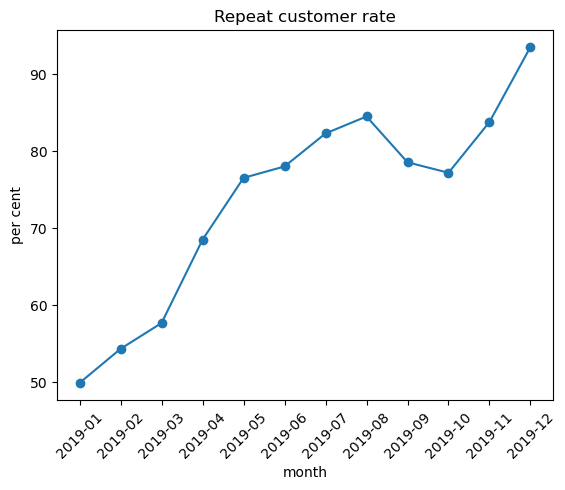

In [138]:
months = ['2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig, ax = plt.subplots(1,1)
ax.plot(months, repeat_rates, label = 'repeat rate', marker = 'o')
ax.set_xlabel('month')
ax.set_xticks(ticks = months)
ax.set_xticklabels(labels = months, rotation = 45)
#ax.set(ylim = (25,70))
ax.set_ylabel('per cent')
#ax.hlines(y=65, xmin = 0, xmax = 11, color='m', linestyle='--')
ax.set_title('Repeat customer rate')